In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from scipy.optimize import fsolve
import matplotlib.dates as mdates
import datetime as dt
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy import stats

def datetime_range(start, events):
    diffs=np.diff(events)
    dates=[]
    dates.append(start)
    for i,d in enumerate(diffs):
        ne=dates[i]+timedelta(days=d)
        dates.append(ne)
    return dates

# Data processing

In [3]:
df_pre=pd.read_excel('csvs/verona.xlsx',0)
print(df_pre.tail(1))
df_post=pd.read_excel('csvs/verona.xlsx',1)
int_day=pd.to_datetime('2019-04-08')
print(int_day)
data=pd.concat([df_pre,df_post],ignore_index=True)
data['week']=pd.date_range("20180305", "20200504", freq='W-MON')
data['Day']=pd.Series(7*data.index+1)
data.rename(columns={'N_CSKP_col_patients':'Sensitive',
                   'N-CRKP_col_patients':'Resistant',
                  'N_KPfree':'Free'},inplace=True)

data

    N_CSKP_col_patients  N-CRKP_col_patients  N_KPfree
56                    0                    1        38
2019-04-08 00:00:00


Sensitive  Resistant  Free       week  Day
0            0          1    36 2018-03-05    1
1            1          1    32 2018-03-12    8
2            1          1    32 2018-03-19   15
3            0          1    38 2018-03-26   22
4            1          0    42 2018-04-02   29
..         ...        ...   ...        ...  ...
109          0          1    19 2020-04-06  764
110          0          0    26 2020-04-13  771
111          0          0    16 2020-04-20  778
112          0          0    19 2020-04-27  785
113          0          0    17 2020-05-04  792

[114 rows x 5 columns]

In [5]:
data['n_patients']=data[['Sensitive','Resistant','Free']].sum(1)
data['prevS']=data.Sensitive/data.n_patients
data['prevR']=data.Resistant/data.n_patients
data['prevF']=data.Free/data.n_patients

data['intervention']=data.week>int_day
Fmean_pre=data[data.intervention==False].Free.mean()
Smean_pre=data[data.intervention==False].Sensitive.mean()
Rmean_pre=data[data.intervention==False].Resistant.mean()
occu_pre=0.79
print('Occupancy pre: {:.1f}%'.format(occu_pre*100))
dayspre=400
Sprev_pre=(data[data.intervention==False].Sensitive/data[data.intervention==False].n_patients).mean()
Sprev_pre_std=100*(data[data.intervention==False].Sensitive/data[data.intervention==False].n_patients).std()
print('Sensitive prevalence pre: ',Sprev_pre*100, ' pm ',Sprev_pre_std)
Rprev_pre=(data[data.intervention==False].Resistant/data[data.intervention==False].n_patients).mean()
Rprev_pre_std=100*(data[data.intervention==False].Resistant/data[data.intervention==False].n_patients).std()
print('Resistant prevalence pre: ',Rprev_pre*100, ' pm ',Rprev_pre_std)

Fmean_post=data[data.intervention==True].Free.mean()
Smean_post=data[data.intervention==True].Sensitive.mean()
Rmean_post=data[data.intervention==True].Resistant.mean()
occu_post=0.71#n_mean_post/46
print('\nOccupancy post: {:.1f}%'.format(occu_post*100))
dayspost=daily_data[daily_data.index>int_day].shape[0]
Sprev_post=(data[data.intervention==True].Sensitive/data[data.intervention==True].n_patients).mean()
Sprev_post_std=100*(data[data.intervention==True].Sensitive/data[data.intervention==True].n_patients).std()
print('Sensitive prevalence post: ',Sprev_post*100, ' pm ',Sprev_post_std)
Rprev_post=(data[data.intervention==True].Resistant/data[data.intervention==True].n_patients).mean()
Rprev_post_std=100*(data[data.intervention==True].Resistant/data[data.intervention==True].n_patients).std()
print('Resistance prevalence post: ',Rprev_post*100, ' pm ',Rprev_post_std)


Occupancy pre: 79.0%
Sensitive prevalence pre:  5.680383224242962  pm  4.355998742153054
Resistant prevalence pre:  6.953711116044515  pm  3.83617811929463

Occupancy post: 71.0%
Sensitive prevalence post:  5.358918995972719  pm  5.204958198459931
Resistance prevalence post:  5.764408071694431  pm  4.91964846159308


In [6]:
gelpre=44.27
gelpost=54.97

acc_pre=1357
acc_post=1421

n_mean_pre=occu_pre*46
n_mean_post=occu_post*46
#Totale giorni degenza diviso numero di accessi e trovi la media
pdpre=14382#dayspre*n_mean_pre
pdpost=13008#dayspost*n_mean_post
print('Clinical pdays pre: {}\nclinical pdays post: {}'.format(pdpre,pdpost))

# Average LOS computed as patient days divided by patients
deg_pre=pdpre/acc_pre
deg_post=pdpost/acc_post
print('LOS pre: {}\nLOS post: {}'.format(deg_pre,deg_post))

Clinical pdays pre: 14382
clinical pdays post: 13008
deg days pre: 10.598378776713338
deg days post: 9.15411681914145


## Data plots

Intervention on:  2019-04-08 00:00:00


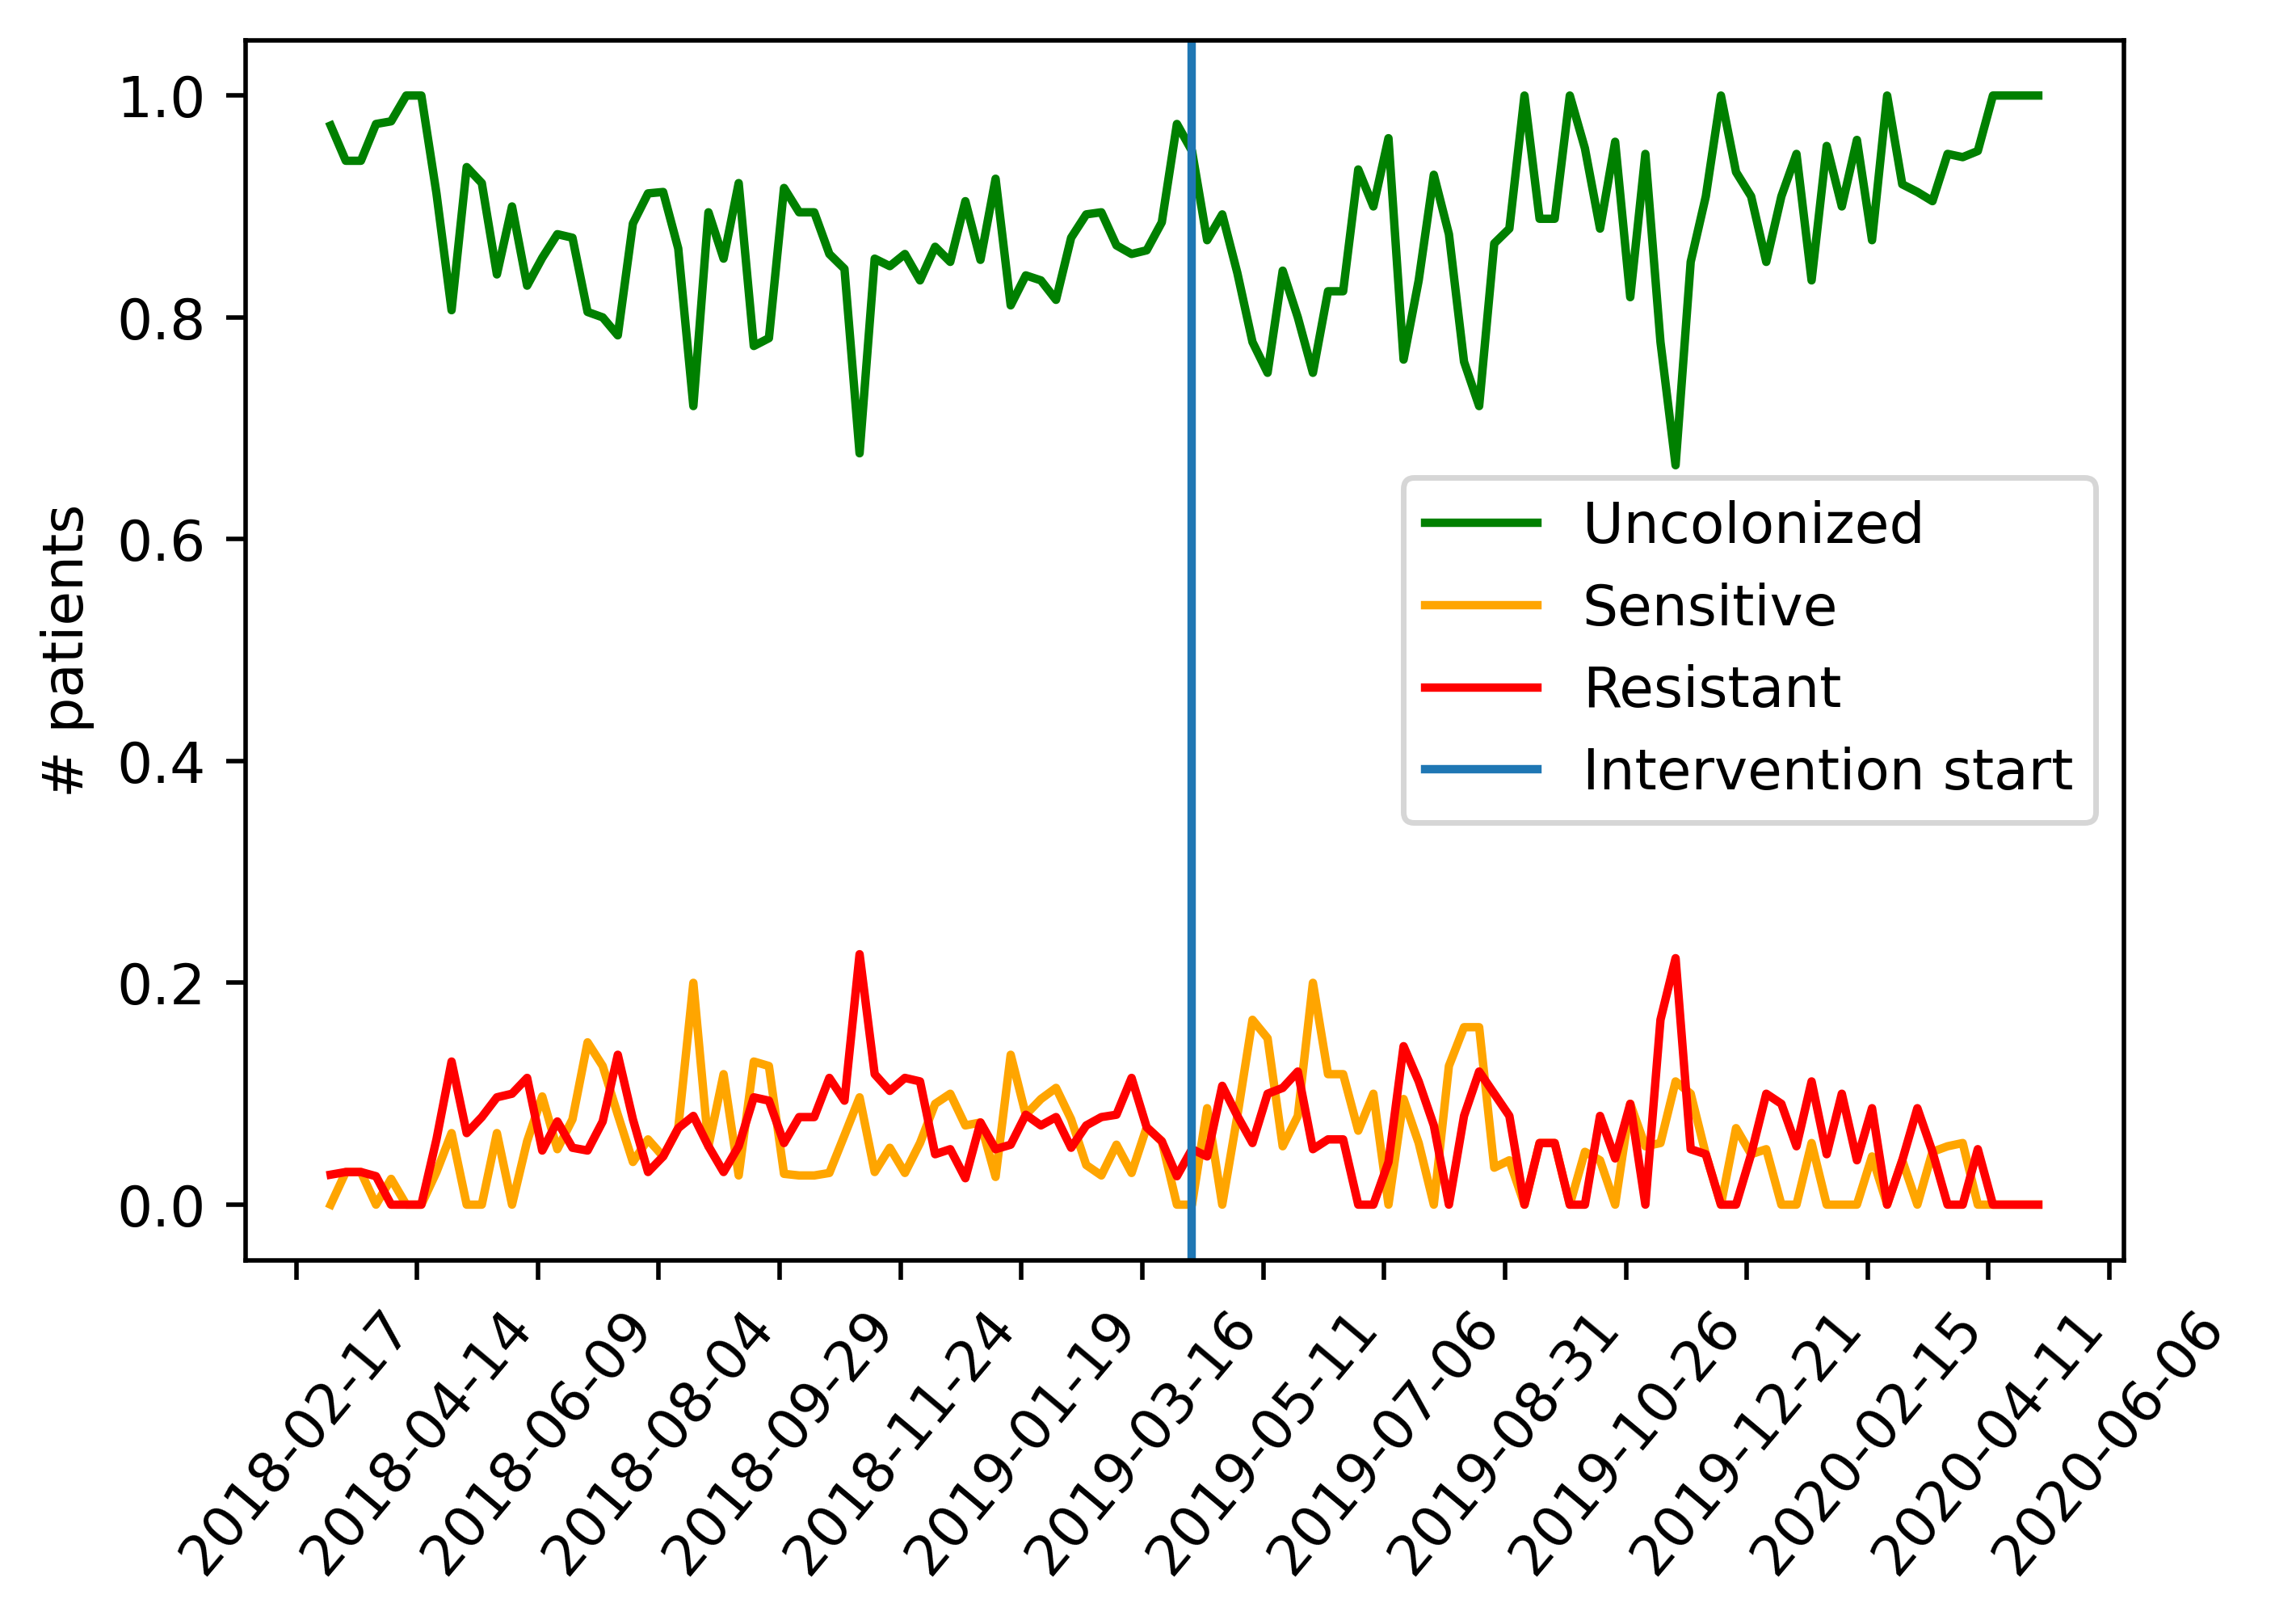

In [7]:
f,ax=plt.subplots(1,1,dpi=500)
plt.plot(data.week,data.prevF,color='green', label='Uncolonized')
plt.plot(data.week,data.prevS,color='orange',label='Sensitive')
plt.plot(data.week,data.prevR,color='red',label='Resistant')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.axvline(int_day, label='Intervention start')
plt.ylabel('# patients')
plt.legend()
print('Intervention on: ',int_day)
plt.show()

Intervention on:  2019-04-08 00:00:00


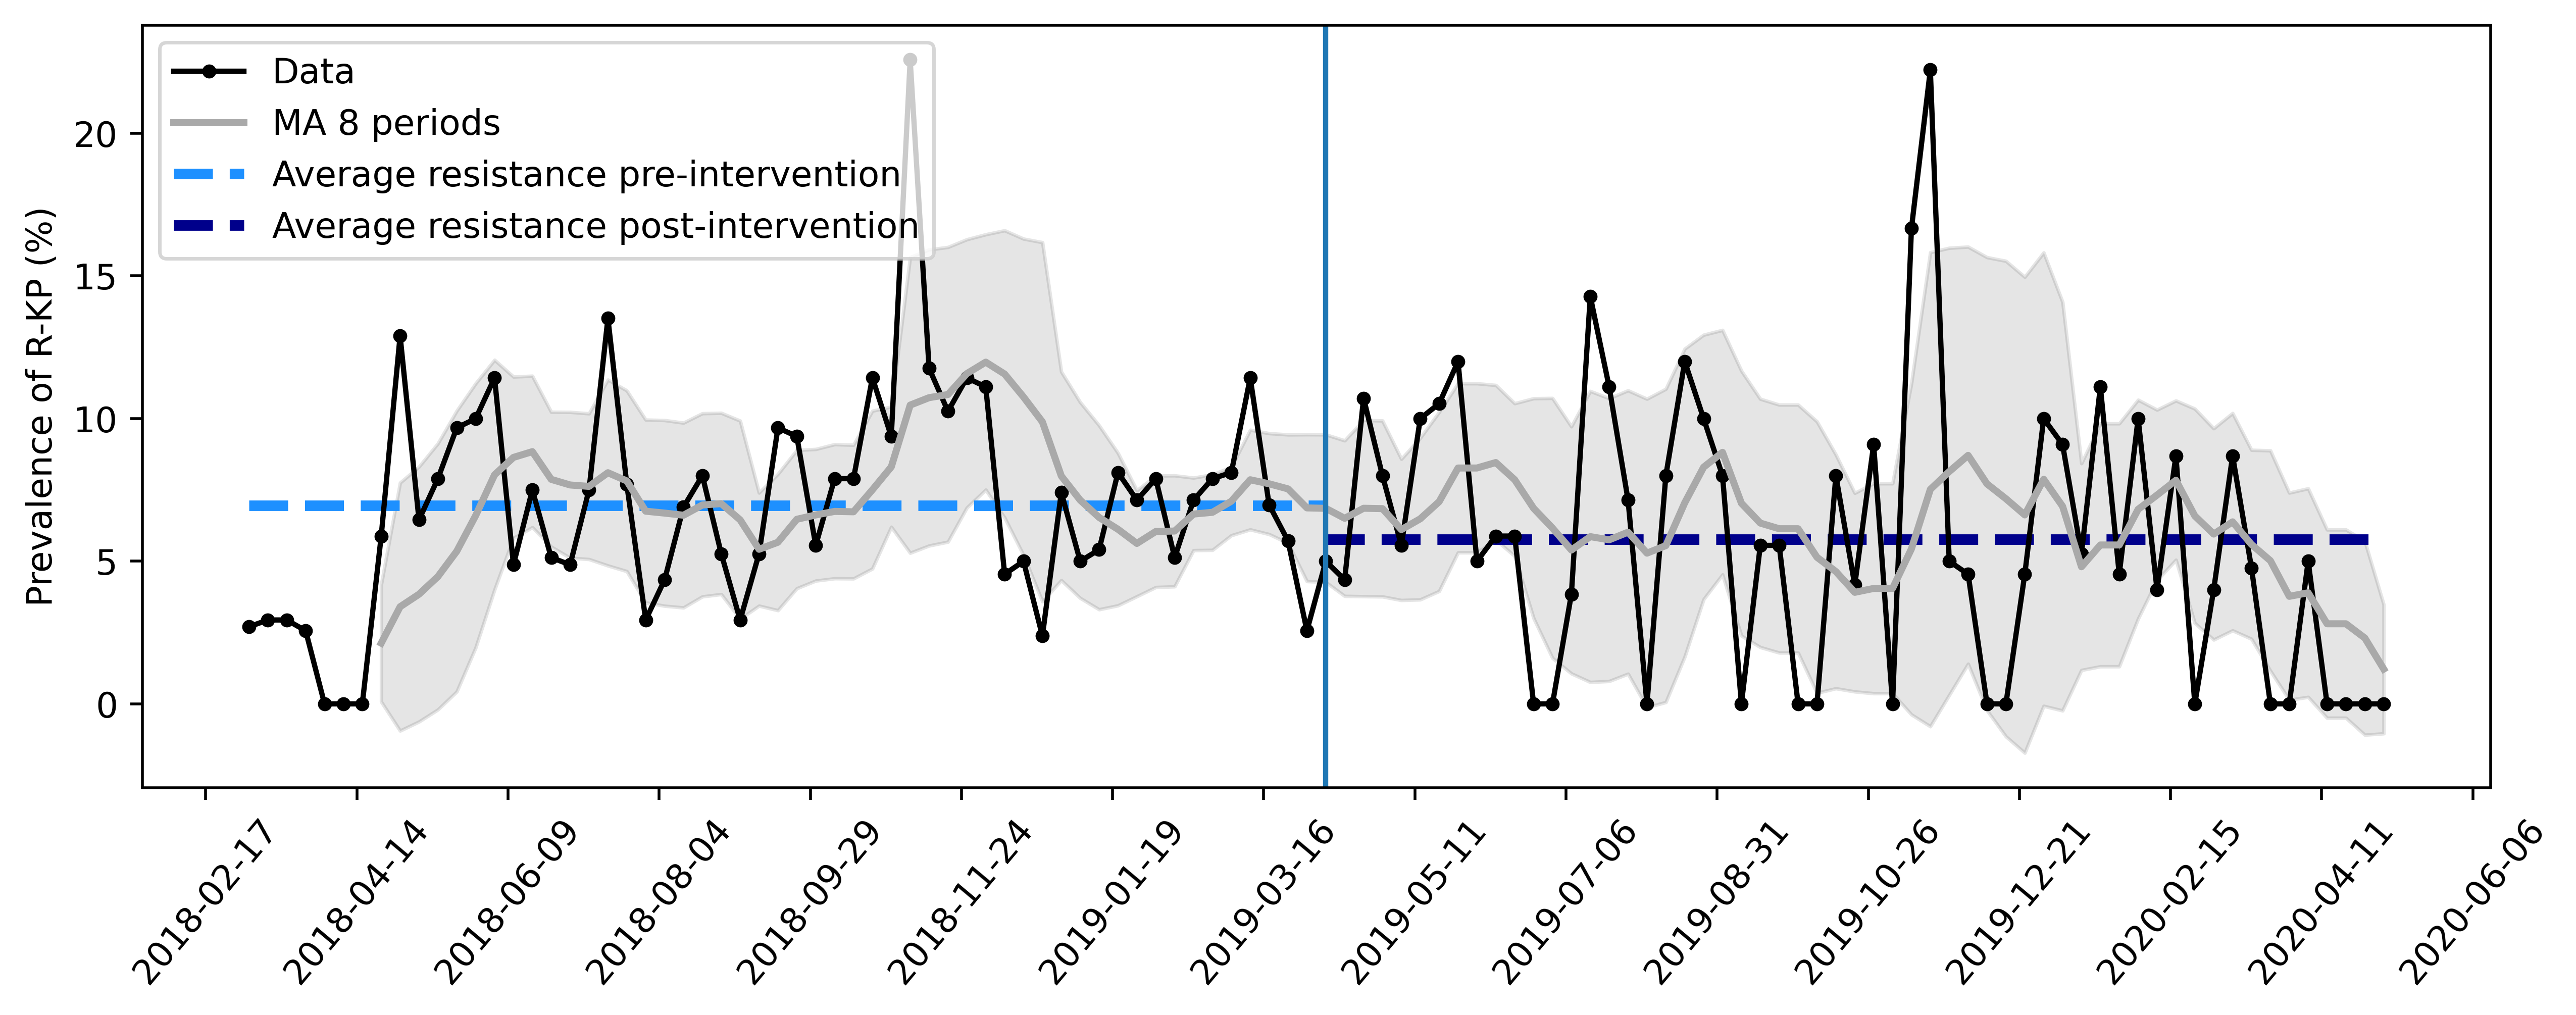

In [66]:
f,ax=plt.subplots(1,1,figsize=(12,4),dpi=500)
#Compute curves of interest:
time_series_df = pd.DataFrame(data.Resistant/data.n_patients*100).set_index(data.week)
smooth_path    = time_series_df.rolling(8).mean()
path_deviation =  time_series_df.rolling(8).std()

under_line     = (smooth_path-path_deviation)[0]
over_line      = (smooth_path+path_deviation)[0]

#Plotting:
#plt.plot(smooth_path, linewidth=2,color='red',marker='o',label='Resistant prevalence (%)',markersize=2) #mean curve.
#plt.fill_between(path_deviation.index, under_line, over_line, color='coral', alpha=.1) #std curves.
ax.plot( time_series_df, marker='o',markersize=3,
             color='black',label='Data')
plt.plot(smooth_path, linewidth=2,color='darkgrey',label='MA 8 periods') #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='black', alpha=.1) #std curves.

#plt.plot(data.week,data.prevR*100 ,color='coral',marker='o',label='Resistant prevalence (%)',markersize=2)
ax.hlines(Rprev_pre*100,xmin=data.week.min(),xmax=int_day, label='Average resistance pre-intervention',color='dodgerblue',linestyle='--',linewidth=3)
ax.hlines(Rprev_post*100, xmin=int_day,xmax=data.week.max(), label='Average resistance post-intervention',color='darkblue',linestyle='--',linewidth=3)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
ax.set_ylabel('Prevalence of R-KP (%)')
plt.legend(loc='upper left')
plt.axvline(int_day, label='Intervention start')
print('Intervention on: ',int_day)
plt.show()

Intervention on:  2019-04-08 00:00:00


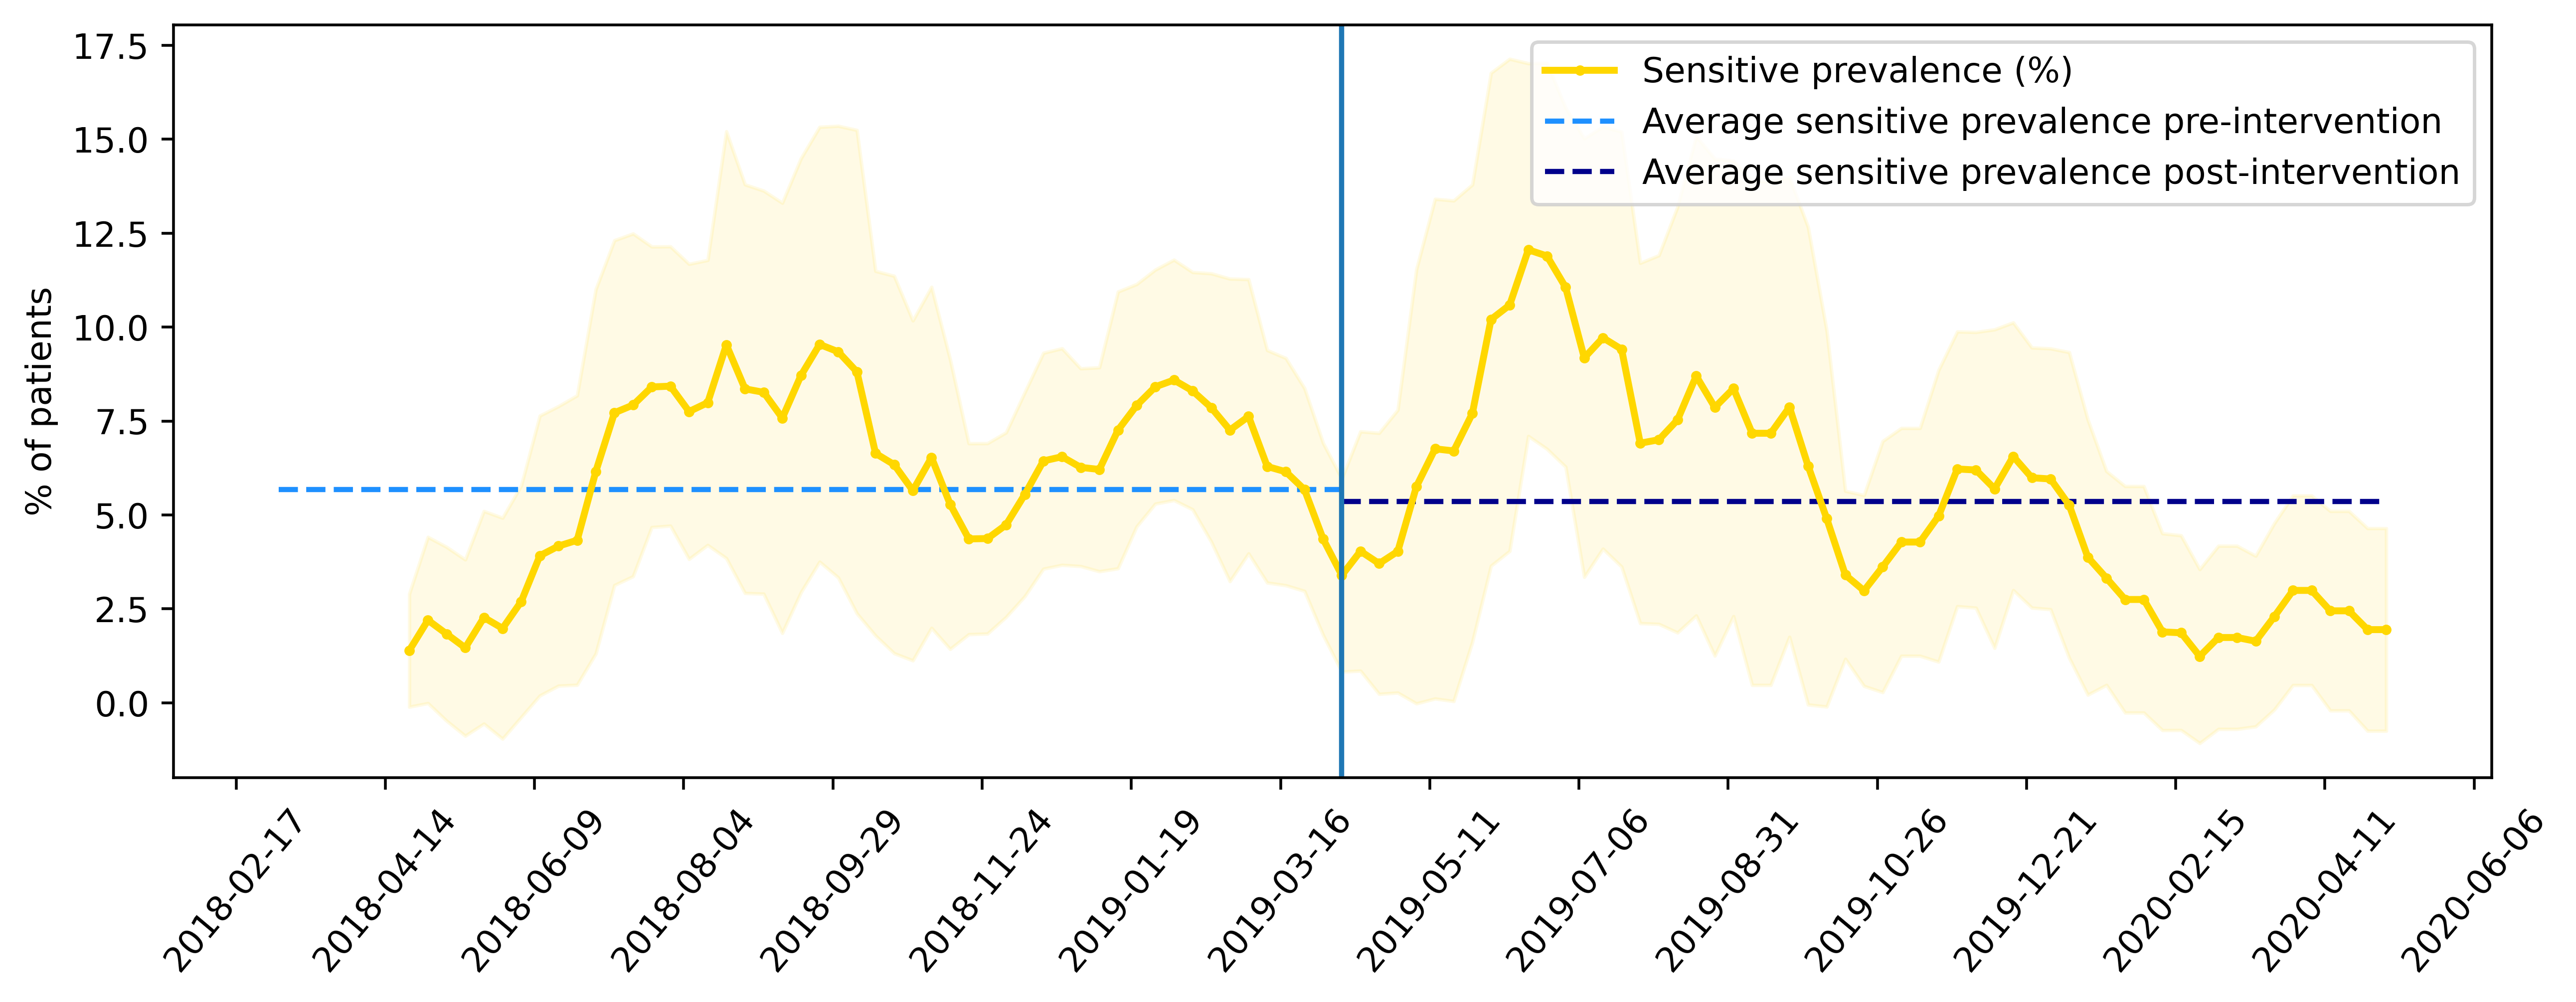

In [50]:
f,ax=plt.subplots(1,1,figsize=(12,4),dpi=500)
#Compute curves of interest:
time_series_df = pd.DataFrame(data.Sensitive/data.n_patients*100).set_index(data.week)
smooth_path    = time_series_df.rolling(8).mean()
path_deviation =  time_series_df.rolling(8).std()

under_line     = (smooth_path-path_deviation)[0]
over_line      = (smooth_path+path_deviation)[0]

#Plotting:
plt.plot(smooth_path, linewidth=2,color='gold',marker='o',label='Sensitive prevalence (%)',markersize=2) #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='gold', alpha=.1) #std curves.


#plt.plot(data.week,data.prevR*100 ,color='coral',marker='o',label='Resistant prevalence (%)',markersize=2)
ax.hlines(Sprev_pre*100,xmin=data.week.min(),xmax=int_day, label='Average sensitive prevalence pre-intervention',color='dodgerblue',linestyle='--')
ax.hlines(Sprev_post*100, xmin=int_day,xmax=data.week.max(), label='Average sensitive prevalence post-intervention',color='darkblue',linestyle='--')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.ylabel('% of patients')
plt.legend()
plt.axvline(int_day, label='Intervention start')
print('Intervention on: ',int_day)
plt.show()

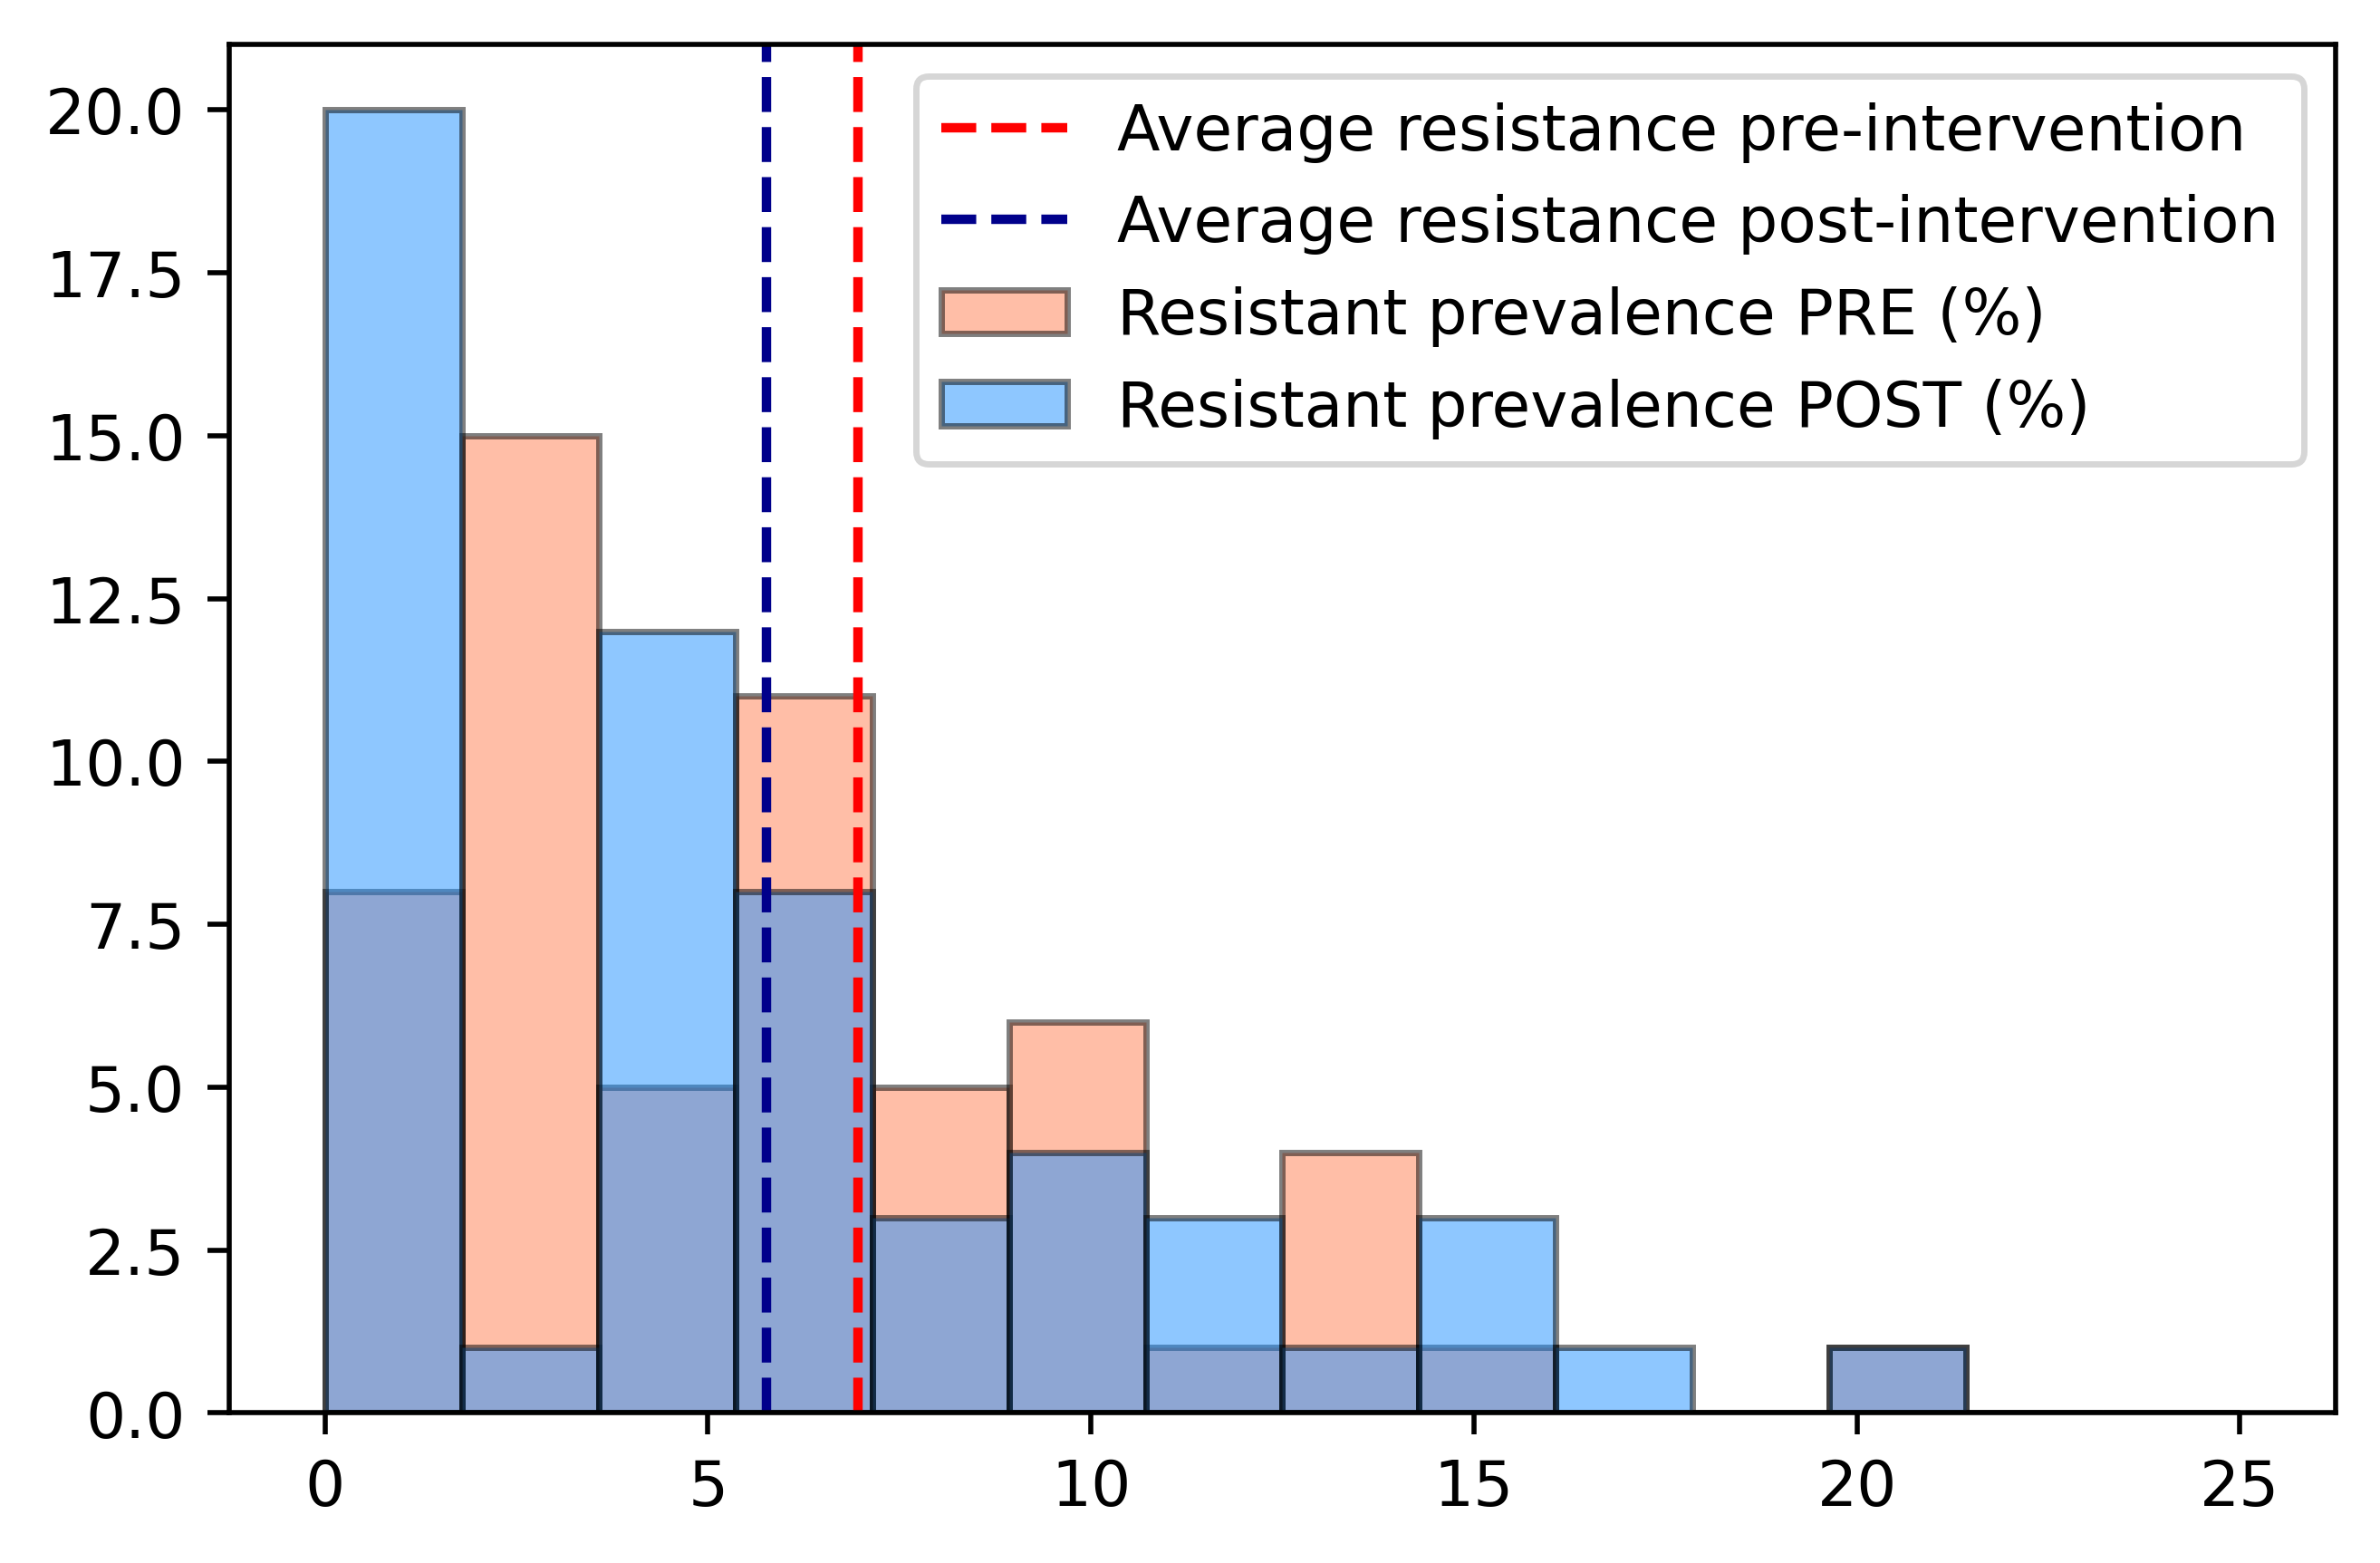

In [15]:
f,ax=plt.subplots(1,1,dpi=500)
r1=(data.prevS*100).iloc[:57]
r2=(data.prevS*100).iloc[57:]
bins = np.linspace(0, 25, 15)

plt.hist(r1 ,bins,facecolor='coral',label='Resistant prevalence PRE (%)',alpha=.5,edgecolor='black')
plt.axvline(Rprev_pre*100, label='Average resistance pre-intervention',color='red',linestyle='--')
plt.hist(r2 ,bins,facecolor='dodgerblue',label='Resistant prevalence POST (%)',alpha=.5,edgecolor='black')
plt.axvline(Rprev_post*100, label='Average resistance post-intervention',color='darkblue',linestyle='--')
plt.legend()
plt.show()

# Model fit pre

In [18]:
days=7*114

# Colonized fraction at admission
pr=0.006#0.01
ps=0.025#0.02 
pf=1-ps-pr
# Beds
B=46
# Patients initial conditions
Np=28 #data mean (not used)
F0=36
S0=0
R0=1

#HCWs
Nh=50/3 # about 1/3 of total HCWs each turn
q=0.01#cohorting from Austin 1999
Hf0=Nh
Hs0=0
Hr0=0
print('Initial conditions: ',F0,S0,R0)
print('HCWs: ',Hf0)

# Clearance and decontamination rate
wrf=1/30 #blanqart
wsf=1/30 #blanqart
muh=1/(1/24) #sypsa

# Discharge rate (inverse of LOS)
dmeanpre=1/deg_pre
dmeanpost=1/deg_post
print('LOS mean pre: ',1/dmeanpre)
print('LOS mean post: ',1/dmeanpost)

# Daily accession rate
apre=acc_pre/dayspre
ap=acc_post/dayspost
print('apre= ',apre)
print('apost= ',ap)
a=apre
dmean=dmeanpre

# We average the HCW/patient ratio in the cardiochirugic (CHI) and intensive (ICU) units weighting on their relative number of beds
nprCHI=1/12
nprICU=1/2
npr=1/((21/nprCHI+29/nprICU)/50) 
print('Average npr inverted:',1/npr)
Kh=(21*1.4*24+29*3.5*0.62*16*0.45)/50 #hourly visits * HCW fraction of visits * daylight hours * fraction of visis with contacts 
print('Daily contacts per patient:',Kh)
Kh=Kh/Nh
print('Daily contacts per patient per HCW:',Kh) 

# Transmission probability
alpha=0.45 #Dal Ben
gamma=0.214 #Sypsa
# Gel usage for the initial guess of hand hygiene
gel=gelpre
pdp=pdpre
n_mean=n_mean_pre
ndays=dayspre
h=(gel/1000*pdp/0.004) / (Kh*Nh*pdp)#(Kh*ndays*Nh*n_mean)
print('Compliance initial guess:',h)
noth=1-h

# DOTs from hospital data, relative risks from Li et al.
DOT_dict_pre={'BL':100.46/1000,'Cephal':47.66/1000,'Carbap':61.05/1000,'Floroq':21.64/1000}
Risk_dict ={'BL':2.28,'Cephal':4.52,'Carbap':3.99,'Floroq':1.75} #Li2020, Ofner-Agostini2009
DOT=sum(list(DOT_dict_pre.values()))
# Weighted average of relative risk weghted on hospital DOTs
AR=sum([Risk_dict[tipo]*DOT_dict_pre[tipo] for tipo in DOT_dict_pre.keys()])/DOT
TD=DOT/dmean
Tfrac=TD*dmean
# Final A parameter, from Austin 1999
ATR=1+Tfrac*(AR-1)
print('Daily DOT per patient:',DOT)
print('Weighted average of risk:',AR)
print('Treatment duration: ',TD)
print('Antibiotic trasm risk increase: ',ATR)


intervenuto=False
tempo=np.linspace(1,days,days)

params = Parameters()
params.add('q', value=q, min=0, max=0.2,vary=True)
#params.add('Kh', value=Kh, min=0, max=25,vary=True)
params.add('h', value=h, min=0., max=1,vary=True)
params.add('Tfrac', value=Tfrac, min=0, max=1/3,vary=False)
params.add('AR',value=AR,min=min(Risk_dict.values()),max=max(Risk_dict.values()),vary=False)
params.add('pr', value=pr, min=0, max=0.1,vary=False)
params.add('ps', value=ps, min=0, max=0.1,vary=False)
params.add('dmean',value=dmean,min=1/60,max=1,vary=False)
params.add('a',value=apre,min=0,max=B,vary=False)

Initial conditions:  36 0 1
HCWs:  16.666666666666668
LOS mean pre:  10.598378776713338
LOS mean post:  9.15411681914145
apre=  3.3925
apost=  3.625
Average npr inverted: 6.2
Each HCW follows 0.060 of total beds
Daily contacts per patient: 23.17392
Daily contacts per patient per HCW adjusted: 1.3904352
Compliance guess: 0.4775842844024662
Daily DOT per patient: 0.23080999999999996
Weighted average of risk: 3.1451475239374376
Treatment duration:  2.446211805453205
Antibiotic trasm risk increase:  1.4951214999999998


In [ ]:
def differential(x,tempo,pars):
    F,S,R,Hf,Hs,Hr,In,Rcum,Rtrasm,Radm=x
           
    h=pars['h'].value
    Kh=(gel/1000*pdp/0.004) / (h*ndays*Nh*n_mean)
    noth=1-h
    Tfrac=pars['Tfrac'].value
    AR=pars['AR'].value
    ATR=1+Tfrac*(AR-1)
    pr=pars['pr'].value#*(1-s)
    ps=pars['ps'].value#*(1-s)
    pf=1-ps-pr
    dmean=pars['dmean'].value
    a=pars['a'].value
    
    # Model equations
    dF=wrf*R+wsf*S-Kh*alpha*F*Hr*ATR-Kh*alpha*F*Hs-dmean*F+a*pf
    dS=-wsf*S+Kh*alpha*F*Hs-dmean*S+a*ps
    dR=+Kh*alpha*Hr*F*ATR-wrf*R-dmean*R+a*pr
    dHf=-Kh*gamma*Hf*(S+R)*noth+muh*(Hs+Hr)+h*(Hs+Hr)*(F+S+R)*Kh
    dHs=Kh*gamma*Hf*S*noth-muh*Hs-h*Hs*(F+S+R)*Kh   
    dHr=Kh*gamma*R*Hf*noth-muh*Hr-h*Hr*(F+S+R)*Kh
    dIn=a
    dRcum=Kh*alpha*Hr*F*ATR+a*pr
    dRtrasm=Kh*alpha*Hr*F*ATR
    dRadm=a*pr
    
    return dF,dS,dR,dHf,dHs,dHr,dIn,dRcum,dRtrasm,dRadm

def odesol(x0,t,pars,is_continue):
    q=pars['q'].value
    x0=list(x0)
    x0[3:6]=[val-val*q for val in x0[3:6]]
    #x0=tuple(x0)
    integ=odeint(differential,x0,t,mxstep=100000,args=(pars,))
    return integ

def residual(pars,ts,x0,data,interv):
    res=pd.DataFrame(odesol(x0,ts,pars,interv),columns=['Uncolonized','Sensitive','Resistant',
                                'HCW uncolonized','HCW sensitive',
                                'HCW resistant','New patient',
                                'Rcum','Rtrasm','Radm'])
    res['prevS']=res['Sensitive']/res[['Uncolonized','Sensitive','Resistant']].sum(1)
    res['prevR']=res['Resistant']/res[['Uncolonized','Sensitive','Resistant']].sum(1)
    res['prevF']=res['Uncolonized']/res[['Uncolonized','Sensitive','Resistant']].sum(1)
    data_fit=data[data.intervention==interv]
    return np.concatenate((data_fit.prevS.values-res.prevS.iloc[0::7].values,
                   data_fit.prevR.values-res.prevR.iloc[0::7].values))

In [22]:
x0= F0,S0,R0,Hf0,Hs0,Hr0,F0+S0+R0,R0,0,R0
print(x0)
print(params)
result = minimize(residual, params, args=(tempo[:400], x0,data,False), method='leastsq')
report_fit(result)
#compl_pre=(gelpre/1000*pdpre/0.004) / (result.params['Kh'].value*dayspre*Nh*(1-result.params['q'])*n_mean_pre )
compl_pre=result.params['h']
Kh_pre=(gelpre/1000*pdpre/0.004) / (result.params['h'].value*Nh*pdp )
print('h:',compl_pre)
print('Kh:',Kh_pre)

(36, 0, 1, 16.666666666666668, 0, 0, 37, 1, 0, 1)
Parameters([('q', <Parameter 'q', value=0.01, bounds=[0:0.2]>), ('h', <Parameter 'h', value=0.4775842844024662, bounds=[0.0:1]>), ('Tfrac', <Parameter 'Tfrac', value=0.23080999999999996 (fixed), bounds=[0:0.3333333333333333]>), ('AR', <Parameter 'AR', value=3.1451475239374376 (fixed), bounds=[1.75:4.52]>), ('pr', <Parameter 'pr', value=0.006 (fixed), bounds=[0:0.1]>), ('ps', <Parameter 'ps', value=0.025 (fixed), bounds=[0:0.1]>), ('dmean', <Parameter 'dmean', value=0.09435405367820889 (fixed), bounds=[0.016666666666666666:1]>), ('a', <Parameter 'a', value=3.3925 (fixed), bounds=[0:46]>)])
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 116
    # variables        = 2
    chi-square         = 0.17489561
    reduced chi-square = 0.00153417
    Akaike info crit   = -749.670119
    Bayesian info crit = -744.162939
[[Variables]]
    q:      2.2780e-04 +/- 78.1470194 (34305489.72%) (init

In [23]:
emcee_kws= dict(steps=1000, burn=300, thin=20, is_weighted=False,workers=16,
                 progress=True)

x0= F0,S0,R0,Hf0,Hs0,Hr0,F0+S0+R0,R0,0,R0
print(x0)
print(result.params)
#result.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))
result = minimize(residual, result.params, args=(tempo[:400], x0,data,False), method='emcee' , **emcee_kws)
report_fit(result)
#compl_pre=(gelpre/1000*pdpre/0.004) / (result.params['Kh'].value*dayspre*Nh*(1-result.params['q'])*n_mean_pre )
compl_pre=result.params['h']
Kh_pre=(gelpre/1000*pdpre/0.004) / (result.params['h'].value*Nh*pdpre )
print('h:',compl_pre)
print('Kh:',Kh_pre)

(36, 0, 1, 16.666666666666668, 0, 0, 37, 1, 0, 1)
Parameters([('q', <Parameter 'q', value=0.0002277974168607644 +/- 78.1, bounds=[0:0.2]>), ('h', <Parameter 'h', value=0.8666390460743476 +/- 7.98, bounds=[0.0:1]>), ('Tfrac', <Parameter 'Tfrac', value=0.23080999999999996 (fixed), bounds=[0:0.3333333333333333]>), ('AR', <Parameter 'AR', value=3.1451475239374376 (fixed), bounds=[1.75:4.52]>), ('pr', <Parameter 'pr', value=0.006 (fixed), bounds=[0:0.1]>), ('ps', <Parameter 'ps', value=0.025 (fixed), bounds=[0:0.1]>), ('dmean', <Parameter 'dmean', value=0.09435405367820889 (fixed), bounds=[0.016666666666666666:1]>), ('a', <Parameter 'a', value=3.3925 (fixed), bounds=[0:46]>)])


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [53.79969743 33.64567371 88.51825675]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 116
    # variables        = 3
    chi-square         = 114.667052
    reduced chi-square = 1.01475268
    Akaike info crit   = 4.65933483
    Bayesian info crit = 12.9201054
[[Variables]]
    q:          0.10474516 +/- 0.06766314 (64.60%) (init = 0.0002277974)
    h:          0.85505498 +/- 0.00832688 (0.97%) (init = 0.866639)
    Tfrac:      0.23081 (fixed)
    AR:         3.145148 (fixed)
    pr:         0.006 (fixed)
    ps:         0.025 (fixed)
    dmean:      0.09435405 (fixed)
    a:          3.3925 (fixed)
    __lnsigma: -3.24279101 +/- 0.06627033 (2.04%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(q, h) = -0.982
h: <Parameter 'h', value=0.85505

# Model fit post

In [26]:
print('Params pre:', result.params)
integ=odesol(x0,tempo[:400],result.params,is_continue=False)

respre=pd.DataFrame(integ,columns=['Uncolonized','Sensitive','Resistant',
                                'HCW uncolonized','HCW sensitive',
                                'HCW resistant','New patient',
                                'Rcum','Rtrasm','Radm'])
x0post=respre.iloc[-1,:].copy()
x0post[3:6]=[val/(1-result.params['q']) for val in x0post[3:6]]

# We update the model parameters to the post-intervention value
gel=gelpost
pdp=pdpost
n_mean=n_mean_post
ndays=dayspost
h=(gel/1000*pdp/0.004) / (Kh_pre*ndays*Nh*n_mean)
dmean=dmeanpost
a=ap
DOT_dict_post={'BL':90.23/1000,'Cephal':28.87/1000,'Carbap':19.93/1000,'Floroq':6.48/1000}
DOT=sum(list(DOT_dict_post.values()))
AR=sum([Risk_dict[tipo]*DOT_dict_post[tipo] for tipo in DOT_dict_post.keys()])/DOT
TD=DOT/dmean
Tfrac=TD*dmean
ATR=1+Tfrac*(AR-1)
print('Daily DOT per patient:',DOT)
print('Weighted average of risk:',AR)
print('Treatment duration: ',TD)
print('Antibiotic trasm risk increase: ',ATR)
params_post = result.params.copy()
params_post['dmean'].value=dmean
params_post['q'].set(vary=True)
params_post['h'].set(vary=True)
params_post['pr'].set(value=pr,vary=False)
params_post['ps'].set(value=ps,vary=False)
params_post['Tfrac'].set(value=Tfrac,vary=False)
params_post['AR'].set(value=AR,vary=False)
params_post['a'].set(value=ap,vary=False)

# Fit (fitted values do not change significantly from pre)
print('Fit post:')
result_post = minimize(residual, params_post, args=(tempo[407:], x0post,data,True), 
                       method='emcee',**emcee_kws)
report_fit(result_post)
Kh_post=(gelpost/1000*pdpost/0.004) / (result_post.params['h'].value*dayspost*Nh*n_mean_post )

print('Contatti pre:{:.4f}  Compl:{:.4f}'.format(Kh_pre,result.params['h'].value))
print('Contatti post:{:.4f}  Compl:{:.4f}'.format(Kh_post,result_post.params['h'].value))

integ=odesol(x0post,tempo[400:],result_post.params,is_continue=True)

respost=pd.DataFrame(integ,columns=['Uncolonized','Sensitive','Resistant',
                                'HCW uncolonized','HCW sensitive',
                                'HCW resistant','New patient',
                                'Rcum','Rtrasm','Radm'])
res=pd.concat([respre,respost],axis=0)
res['Day']=tempo
IRlist=[]
for i in range(res.shape[0]):
    if i<=30:
        IRlist.append(np.nan)
    else:
        IRlist.append((res.Rtrasm.iloc[i]-res.Rtrasm.iloc[i-30])/(
    res['New patient'].iloc[i]-res['New patient'].iloc[i-30])/30*10000)
res['IR']=IRlist
res['Prevalence R-KP']=res['Resistant']/res[['Uncolonized','Sensitive','Resistant']].sum(axis=1)
res['Prevalence S-KP']=res['Sensitive']/res[['Uncolonized','Sensitive','Resistant']].sum(axis=1)
    
IRpre=(res.Rtrasm.iloc[399]-res.Rtrasm.iloc[0])/(
    pdpre)
    #res['New patient'].iloc[399]-res['New patient'].iloc[0])/dayspre
print('IRpre per 10k pd:',IRpre*10000)
IRp=(res.Rtrasm.iloc[-1]-res.Rtrasm.iloc[400])/(
    pdpost)
    #res['New patient'].iloc[-1]-res['New patient'].iloc[400])/dayspost
print('IRpost per 10k pd:',IRp*10000)
print('IR ratio: ',IRp/IRpre)

mdoccupre=res[res.Day<400][['Uncolonized','Sensitive','Resistant']].sum(1).mean()
mdoccupost=res[res.Day>=400][['Uncolonized','Sensitive','Resistant']].sum(1).mean()
print('\nAvg occupancy Pre= {:.2f}\nAvg occupancy Post= {:.2f}'.format(mdoccupre,mdoccupost))                              

pRpre=res[res.Day<400]['Prevalence R-KP'].mean()*100
pRpost=res[res.Day>400]['Prevalence R-KP'].mean()*100
print('Avg CRKP prev Pre= {:.2f}%\nAvg CRKP prev Post= {:.2f}%'.format(pRpre,pRpost))

pRpre50=res['Prevalence R-KP'].iloc[350:400].mean()*100
pRpost50=res['Prevalence R-KP'].iloc[-50:].mean()*100
print('\n50 last days:\n Avg CRKP prev Pre= {:.2f}%\nAvg CRKP prev Post= {:.2f}%'.format(pRpre50,pRpost50)) 

R0 S:  14.975603224749058
R0 R:  28.74809902600409
Params pre: Parameters([('q', <Parameter 'q', value=0.1047451556783742 +/- 0.0677, bounds=[0:0.2]>), ('h', <Parameter 'h', value=0.8550549780697461 +/- 0.00833, bounds=[0.0:1]>), ('Tfrac', <Parameter 'Tfrac', value=0.23080999999999996 (fixed), bounds=[0:0.3333333333333333]>), ('AR', <Parameter 'AR', value=3.1451475239374376 (fixed), bounds=[1.75:4.52]>), ('pr', <Parameter 'pr', value=0.006 (fixed), bounds=[0:0.1]>), ('ps', <Parameter 'ps', value=0.025 (fixed), bounds=[0:0.1]>), ('dmean', <Parameter 'dmean', value=0.09435405367820889 (fixed), bounds=[0.016666666666666666:1]>), ('a', <Parameter 'a', value=3.3925 (fixed), bounds=[0:46]>), ('__lnsigma', <Parameter '__lnsigma', value=-3.2427910070709416 +/- 0.0663, bounds=[-inf:inf]>)])
Daily DOT per patient: 0.14551000000000003
Weighted average of risk: 2.9350388289464635
Treatment duration:  1.3320155383532728
Antibiotic trasm risk increase:  1.2815675
Fit post:


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:00<00:00,  1.14s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [35.561556   33.2650569  36.00582605]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 112
    # variables        = 3
    chi-square         = 110.365264
    reduced chi-square = 1.01252536
    Akaike info crit   = 4.35321619
    Bayesian info crit = 12.5087128
[[Variables]]
    q:          0.10108198 +/- 0.06857858 (67.84%) (init = 0.1047452)
    h:          0.86831493 +/- 0.00787077 (0.91%) (init = 0.855055)
    Tfrac:      0.14551 (fixed)
    AR:         2.935039 (fixed)
    pr:         0.006 (fixed)
    ps:         0.025 (fixed)
    dmean:      0.1092405 (fixed)
    a:          3.625 (fixed)
    __lnsigma: -2.97154166 +/- 0.06526988 (2.20%) (init = -3.242791)
[[Correlations]] (unreported correlations are < 0.100)
    C(q, h) = -0.912
Contatti pre:0.7766  Compl:0.855

## Plot fit results

Text(0, 0.5, 'Monthly avg. IR per 10k pd')

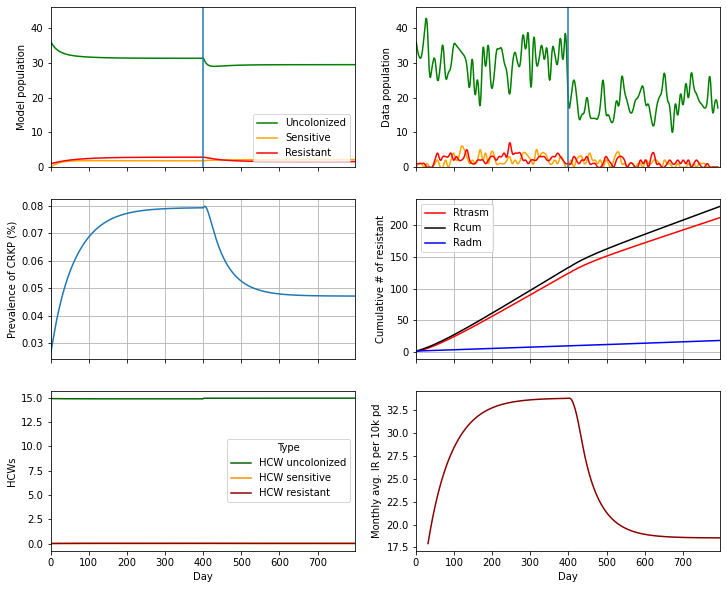

In [30]:
my_pal={'Sensitive':'orange','Resistant':'r','Uncolonized':'g',
        'HCW uncolonized':'darkgreen','HCW sensitive':'darkorange',
        'HCW resistant':'darkred'}
Presplot=res.melt('Day',res.columns[:3],var_name='Type',value_name='Population')
Hresplot=res.melt('Day',res.columns[3:6],var_name='Type',value_name='HCWs')
fig,axs=plt.subplots(3,2, figsize=(12,10),sharex=True)
sns.lineplot(x='Day',y='Population',hue='Type',data=Presplot,ax=axs[0,0],
             palette=my_pal)
axs[0,1].plot(daily_data.Day,daily_data.Free,color='green')
axs[0,1].plot(daily_data.Day,daily_data.Sensitive,color='orange')
axs[0,1].plot(daily_data.Day,daily_data.Resistant,color='red')
#axs[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
#plt.setp( axs[0,1].xaxis.get_majorticklabels(), rotation=50,fontsize=8 )
axs[0,1].axvline(daily_data.loc[int_day,'Day'])
axs[0,0].axvline(daily_data.loc[int_day,'Day'])


sns.lineplot(x='Day',y='Prevalence R-KP',data=res,ax=axs[1,0])
sns.lineplot(x='Day',y='Rtrasm',data=res,ax=axs[1,1],
             color='red',label='Rtrasm')
sns.lineplot(x='Day',y='Rcum',data=res,ax=axs[1,1],
             color='black',label='Rcum')
sns.lineplot(x='Day',y='Radm',data=res,ax=axs[1,1],
             color='blue',label='Radm')
sns.lineplot(x='Day',y='HCWs',hue='Type',data=Hresplot,ax=axs[2,0],
             palette=my_pal)
sns.lineplot(x='Day',y='IR',data=res,ax=axs[2,1],
             color='darkred')

axs[0,0].set_xlim(0,days)
axs[0,0].set_ylim(0,B)
axs[0,0].legend(loc='lower right')
axs[0,1].set_ylim(0,B)
axs[0,1].set_xlim(0,days)
#axs[1,0].set_ylabel('Monthly IR (per 10k pd)')
axs[1,0].set_ylabel('Prevalence of CRKP (%)')
axs[1,0].grid()
axs[1,1].grid()
axs[1,1].legend(loc='upper left')
axs[0,0].set_ylabel('Model population')
axs[0,1].set_ylabel('Data population')
axs[1,1].set_ylabel('Cumulative # of resistant')
axs[2,1].set_ylabel('Monthly avg. IR per 10k pd')

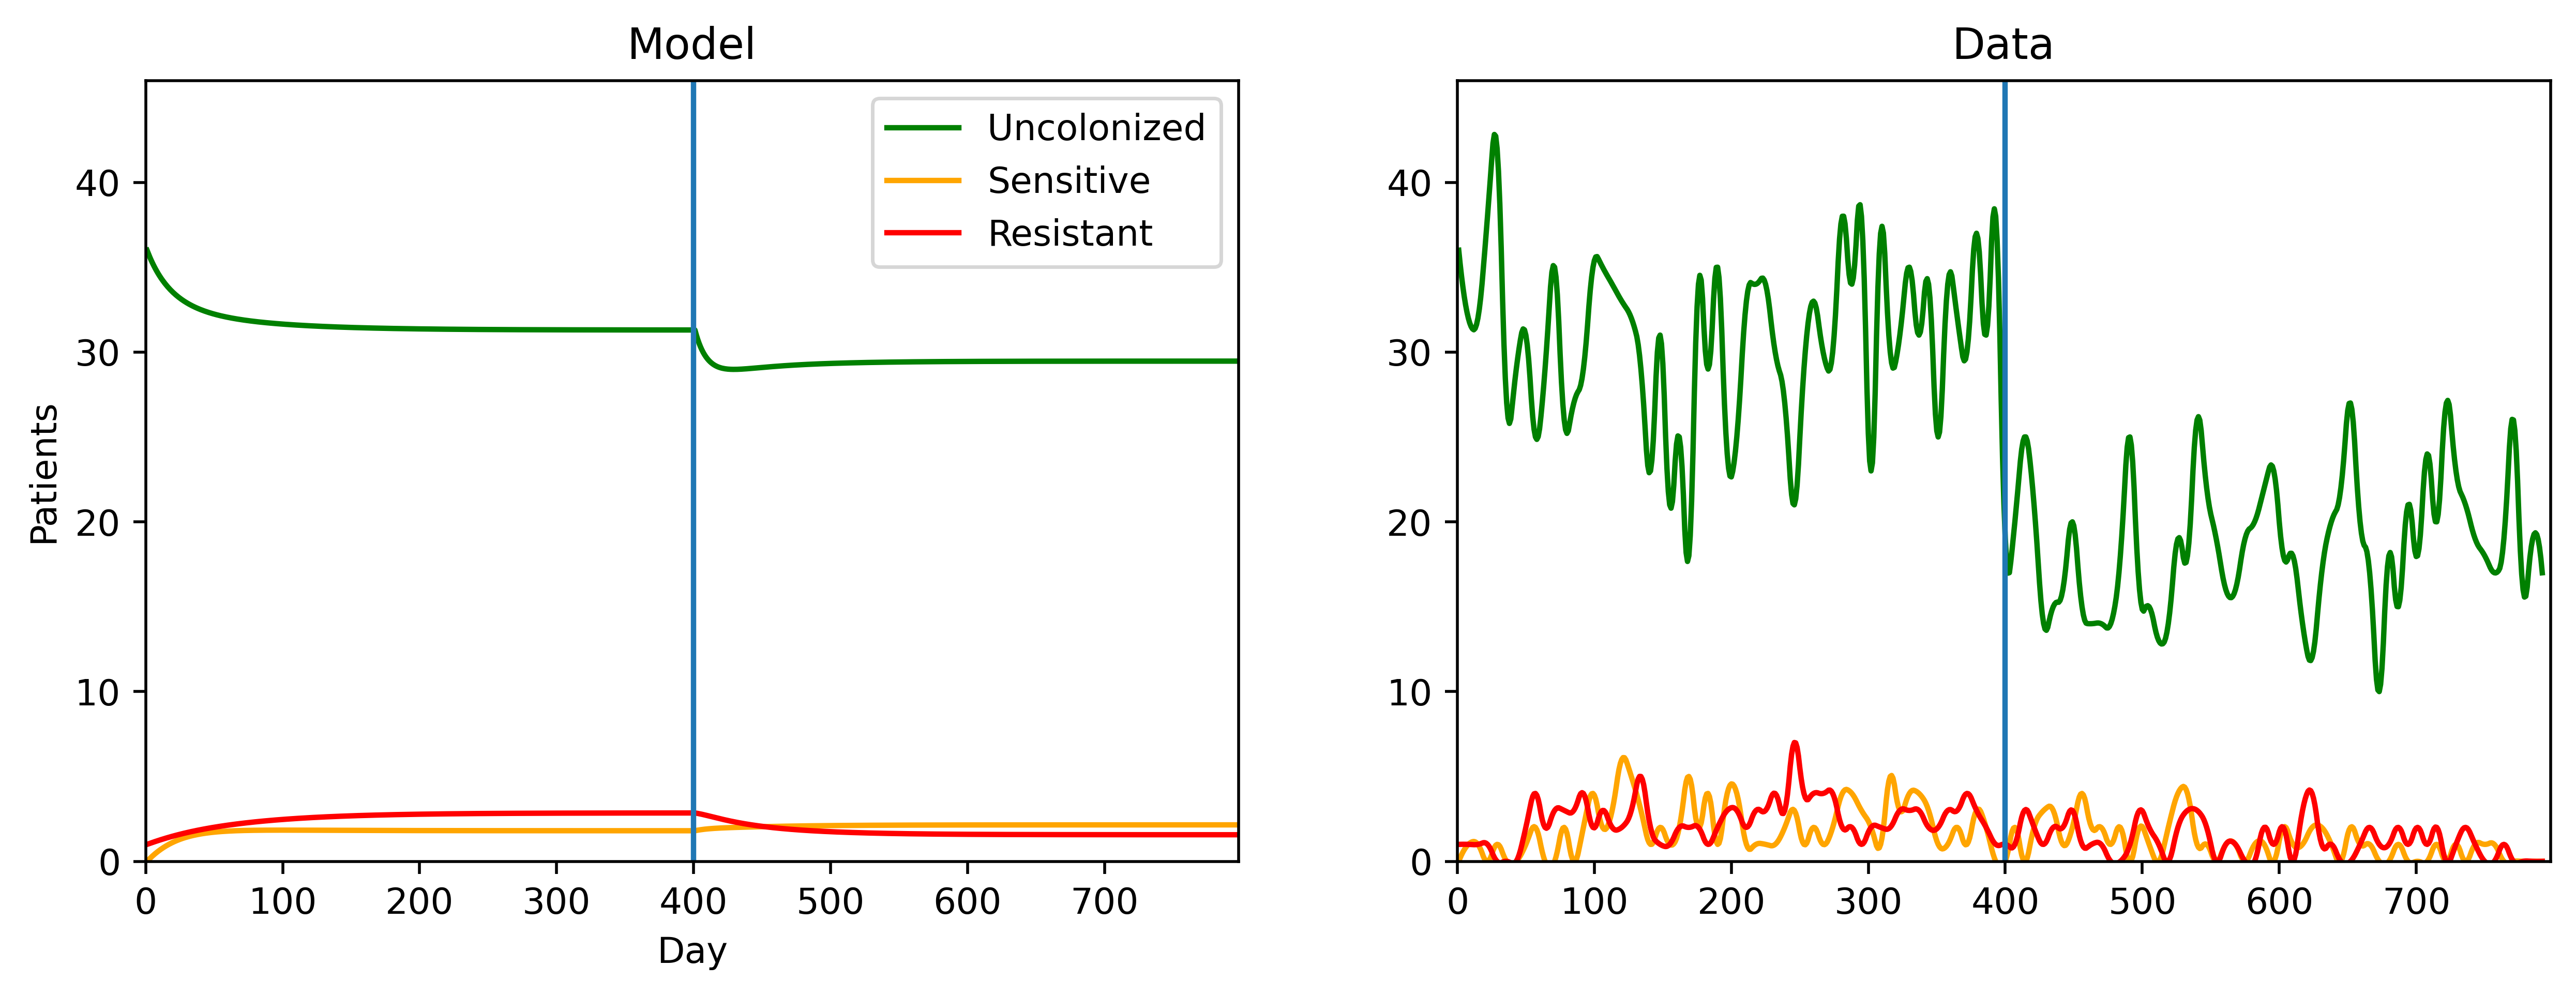

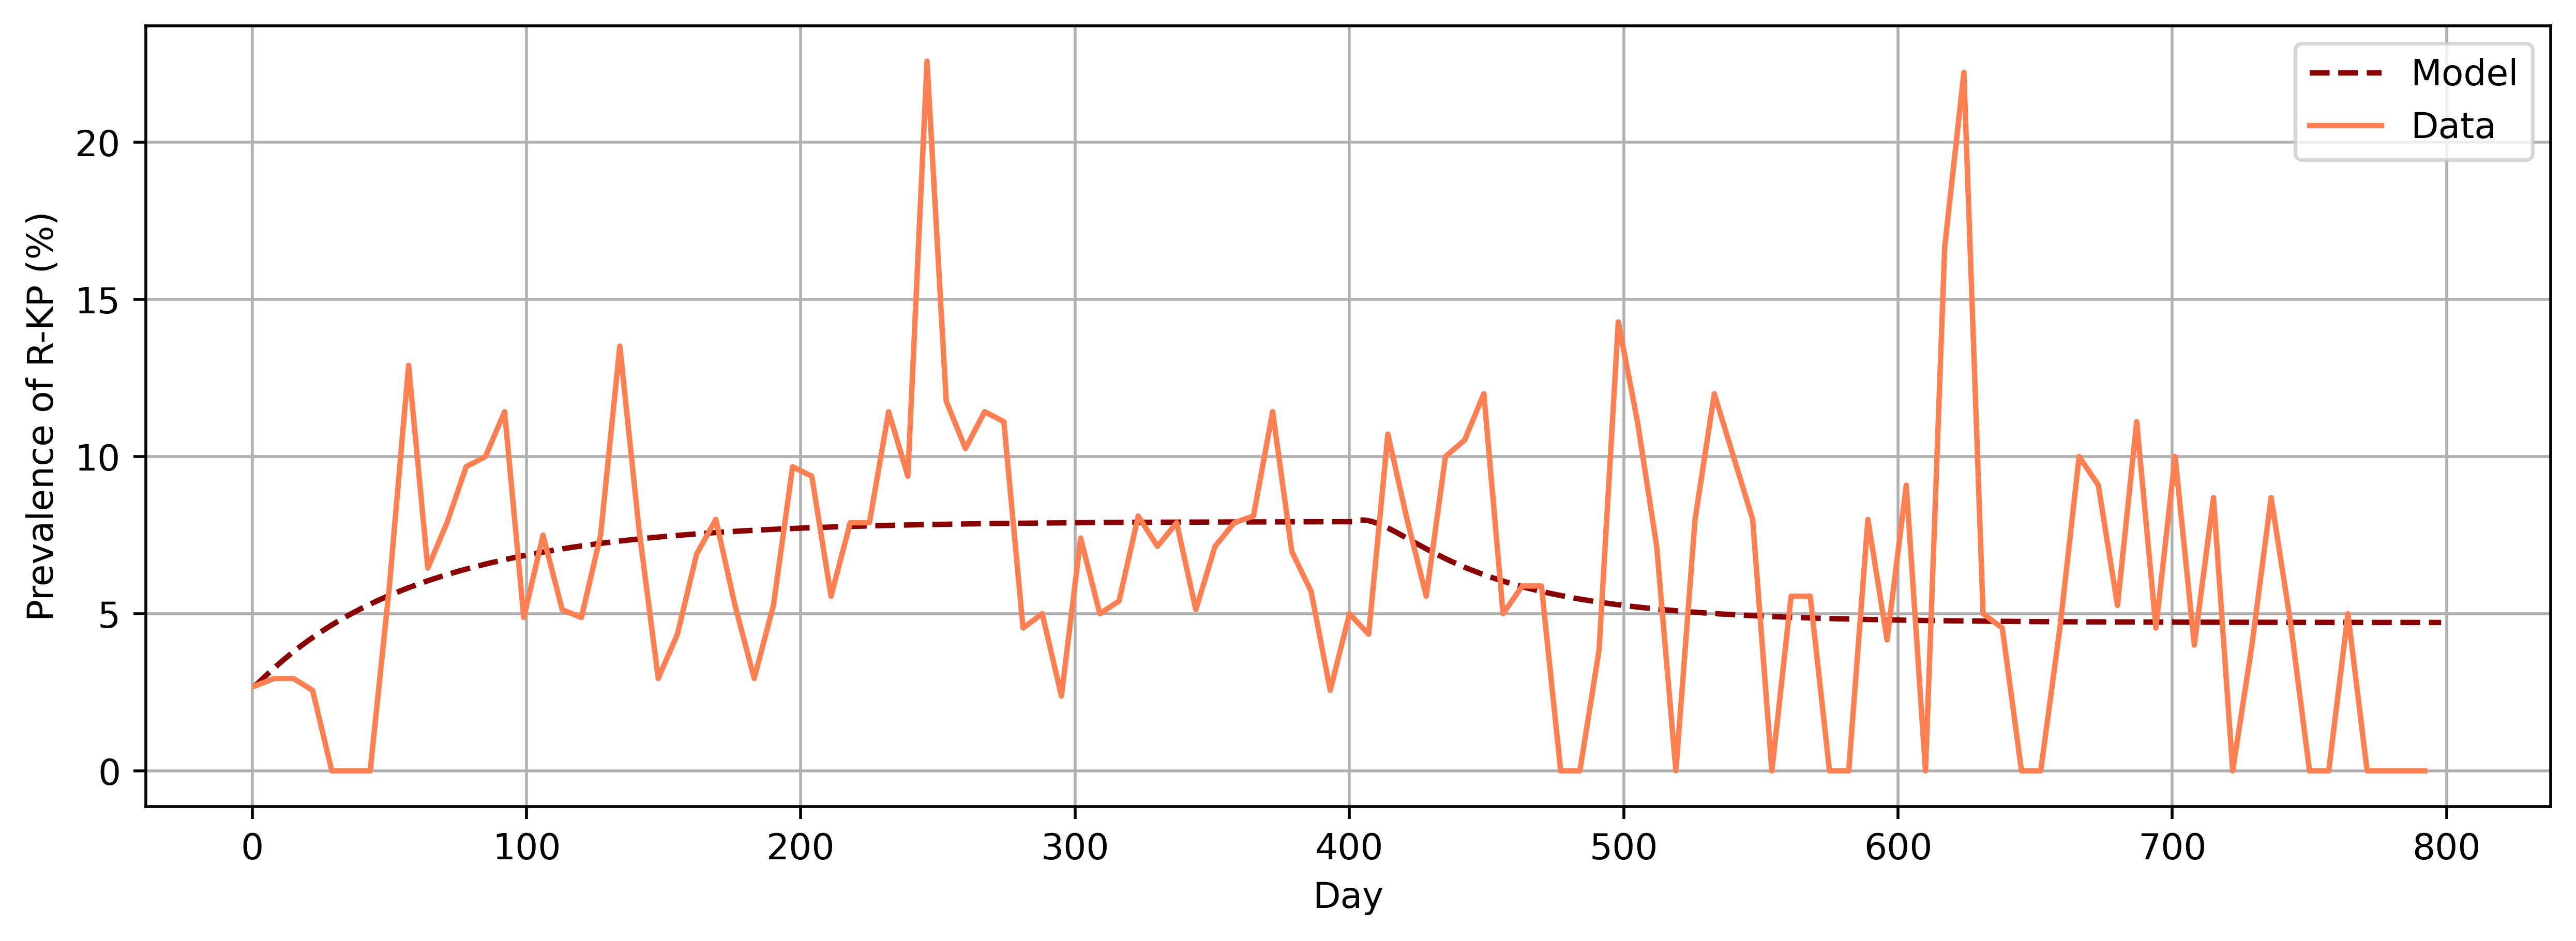

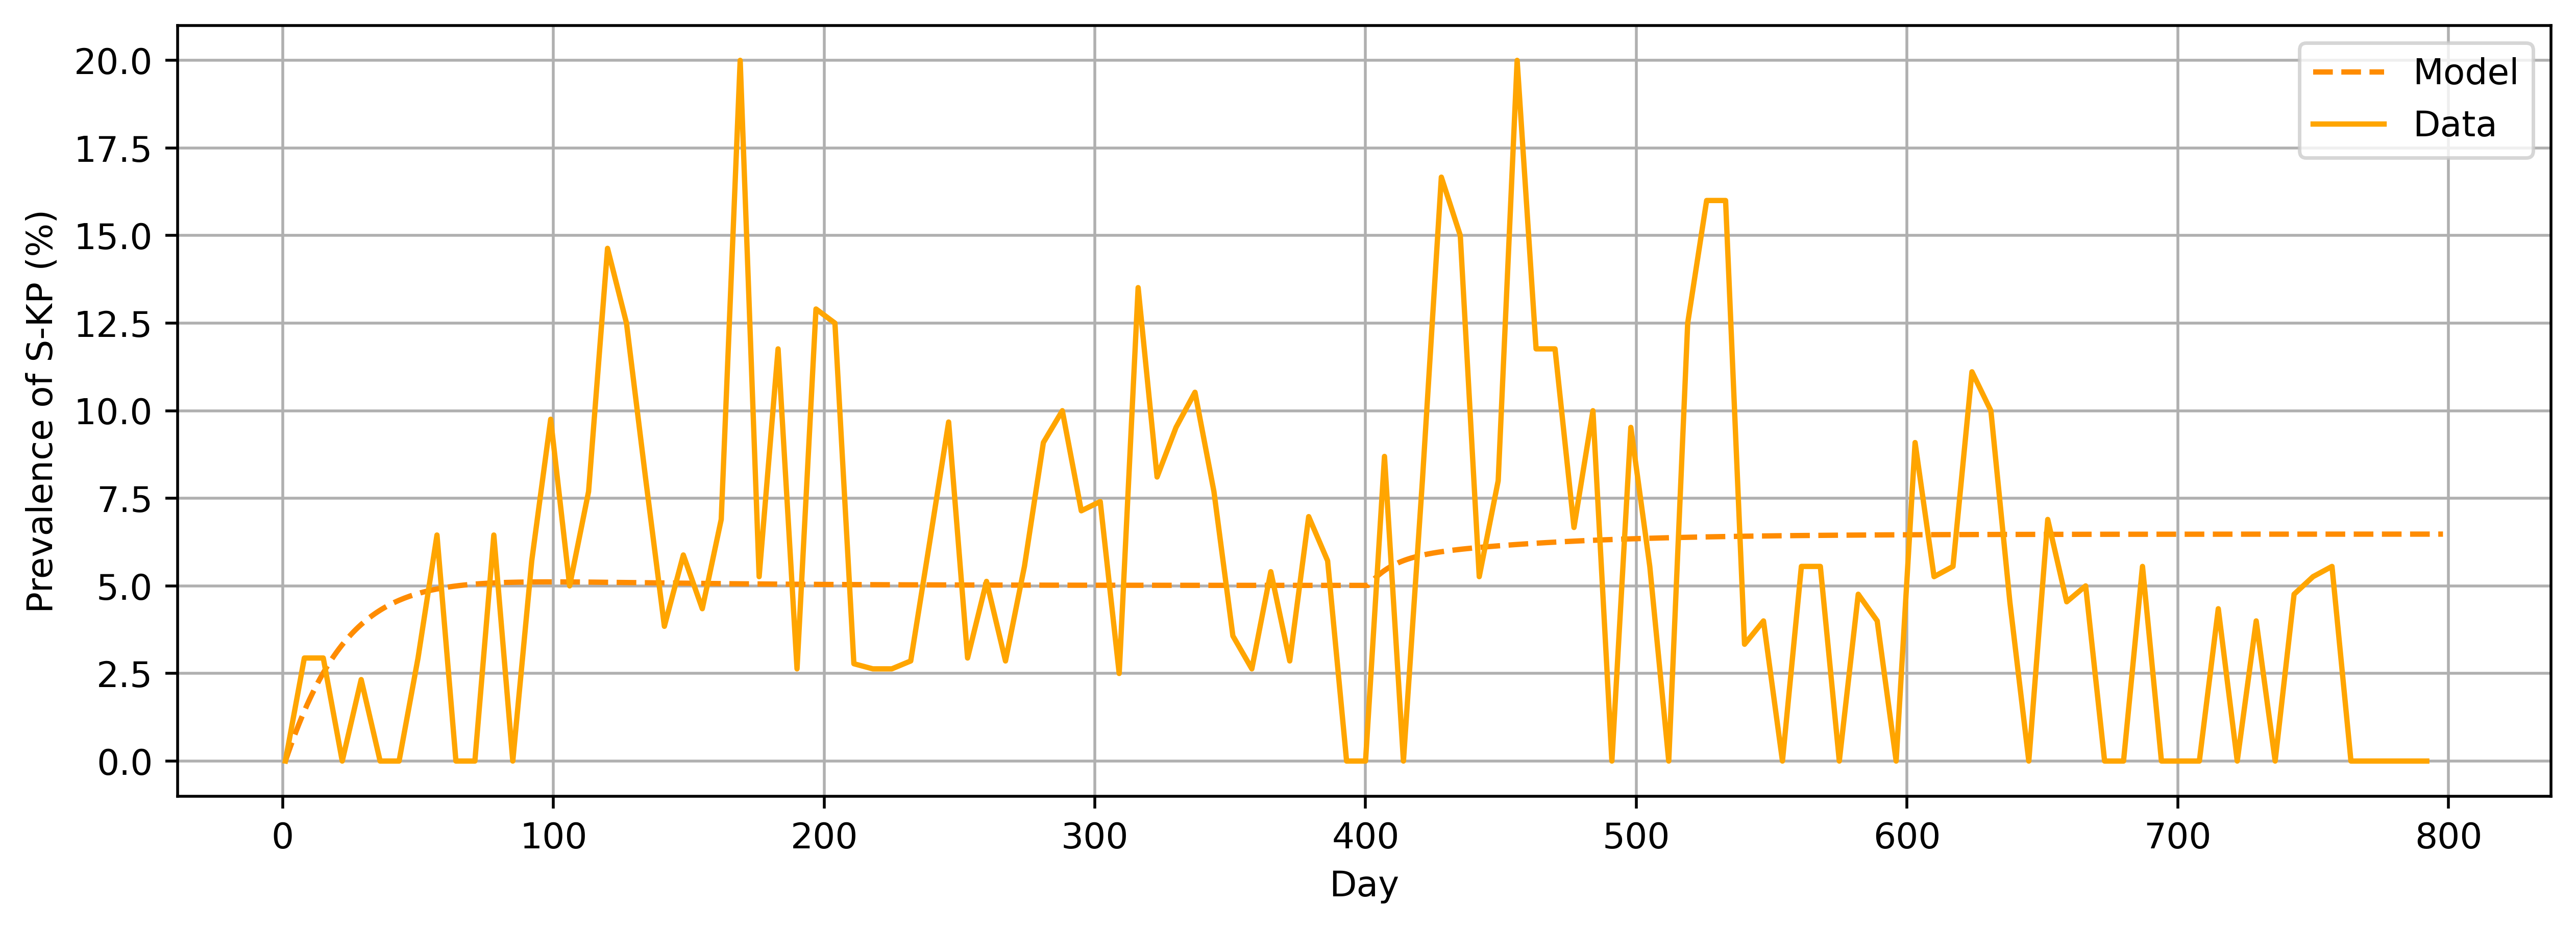

In [31]:
my_pal={'Sensitive':'orange','Resistant':'r','Uncolonized':'g',
        'HCW uncolonized':'darkgreen','HCW sensitive':'darkorange',
        'HCW resistant':'darkred'}
Presplot=res.melt('Day',res.columns[:3],var_name='Type',value_name='Population')
Hresplot=res.melt('Day',res.columns[3:6],var_name='Type',value_name='HCWs')
fig,axs=plt.subplots(1,2, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y='Population',hue='Type',data=Presplot,ax=axs[0],
             palette=my_pal)
axs[1].plot(daily_data.Day,daily_data.Free,color='green')
axs[1].plot(daily_data.Day,daily_data.Sensitive,color='orange')
axs[1].plot(daily_data.Day,daily_data.Resistant,color='red')
#axs[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
#plt.setp( axs[0,1].xaxis.get_majorticklabels(), rotation=50,fontsize=8 )
axs[1].axvline(daily_data.loc[int_day,'Day'])
axs[0].axvline(daily_data.loc[int_day,'Day'])
axs[0].set_xlim(0,days)
axs[0].set_ylim(0,B)
axs[0].legend(loc='upper right')
axs[1].set_ylim(0,B)
axs[1].set_xlim(0,days)
axs[0].set_ylabel('Patients')
axs[0].set_title('Model')
axs[1].set_title('Data')
#axs[1].set_ylabel('Data population')

fig,axs=plt.subplots(1,1, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y=res['Prevalence R-KP']*100,data=res,ax=axs,linestyle='--',color='darkred',label='Model')
axs.plot(data.Day, data.Resistant/data[['Free','Sensitive','Resistant']].sum(1)*100,
             color='coral',label='Data')
axs.legend()
#axs[1,0].set_ylabel('Monthly IR (per 10k pd)')
axs.set_ylabel('Prevalence of R-KP (%)')
axs.grid()

fig,axs=plt.subplots(1,1, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y=res['Prevalence S-KP']*100,data=res,ax=axs,linestyle='--',color='darkorange',label='Model')
axs.plot(data.Day, data.Sensitive/data[['Free','Sensitive','Resistant']].sum(1)*100,
             color='orange',label='Data')
axs.legend()
#axs[1,0].set_ylabel('Monthly IR (per 10k pd)')
axs.set_ylabel('Prevalence of S-KP (%)')
axs.grid()

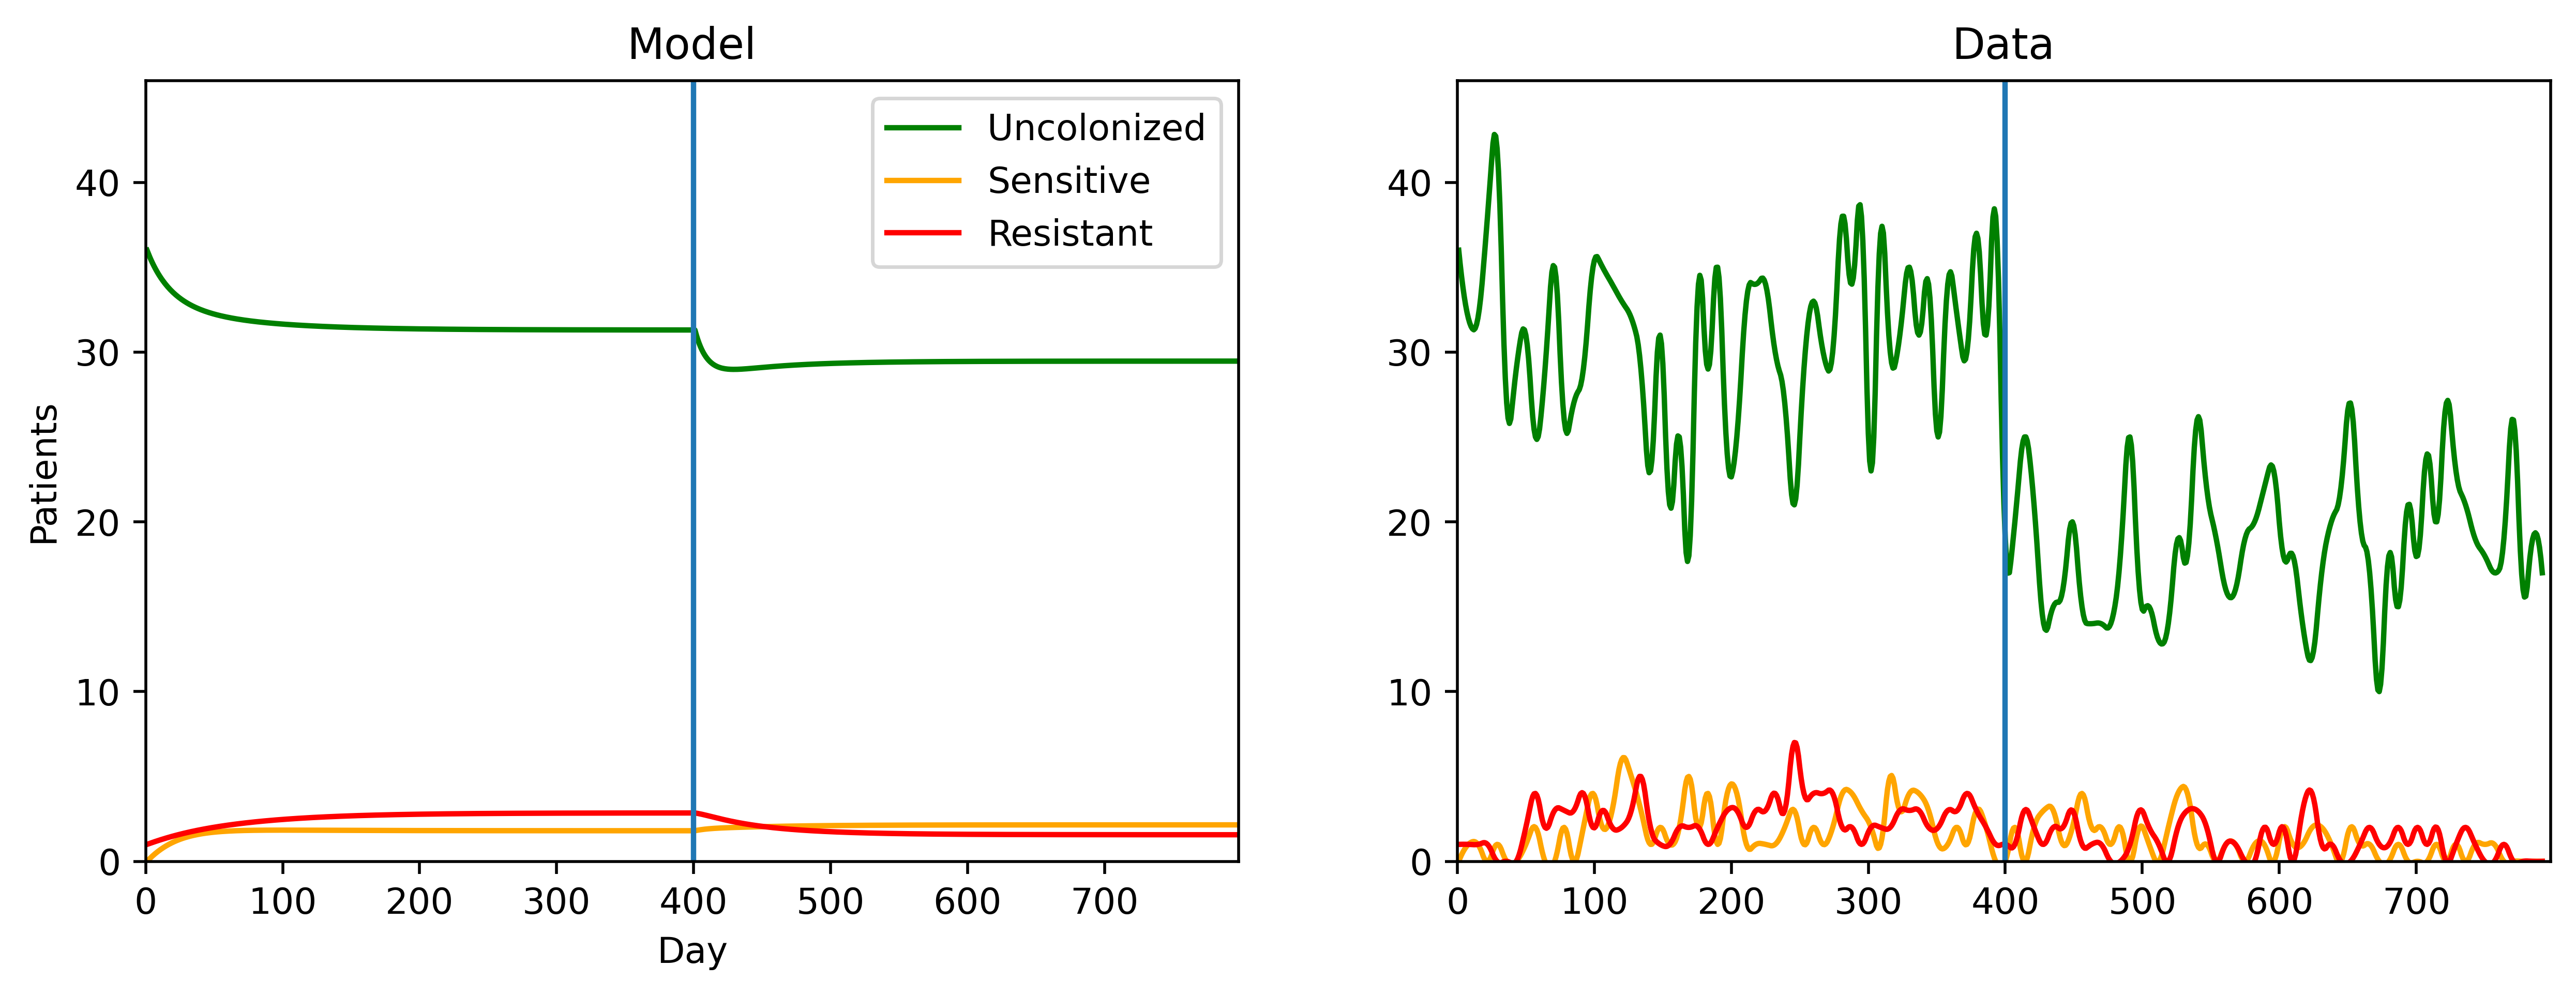

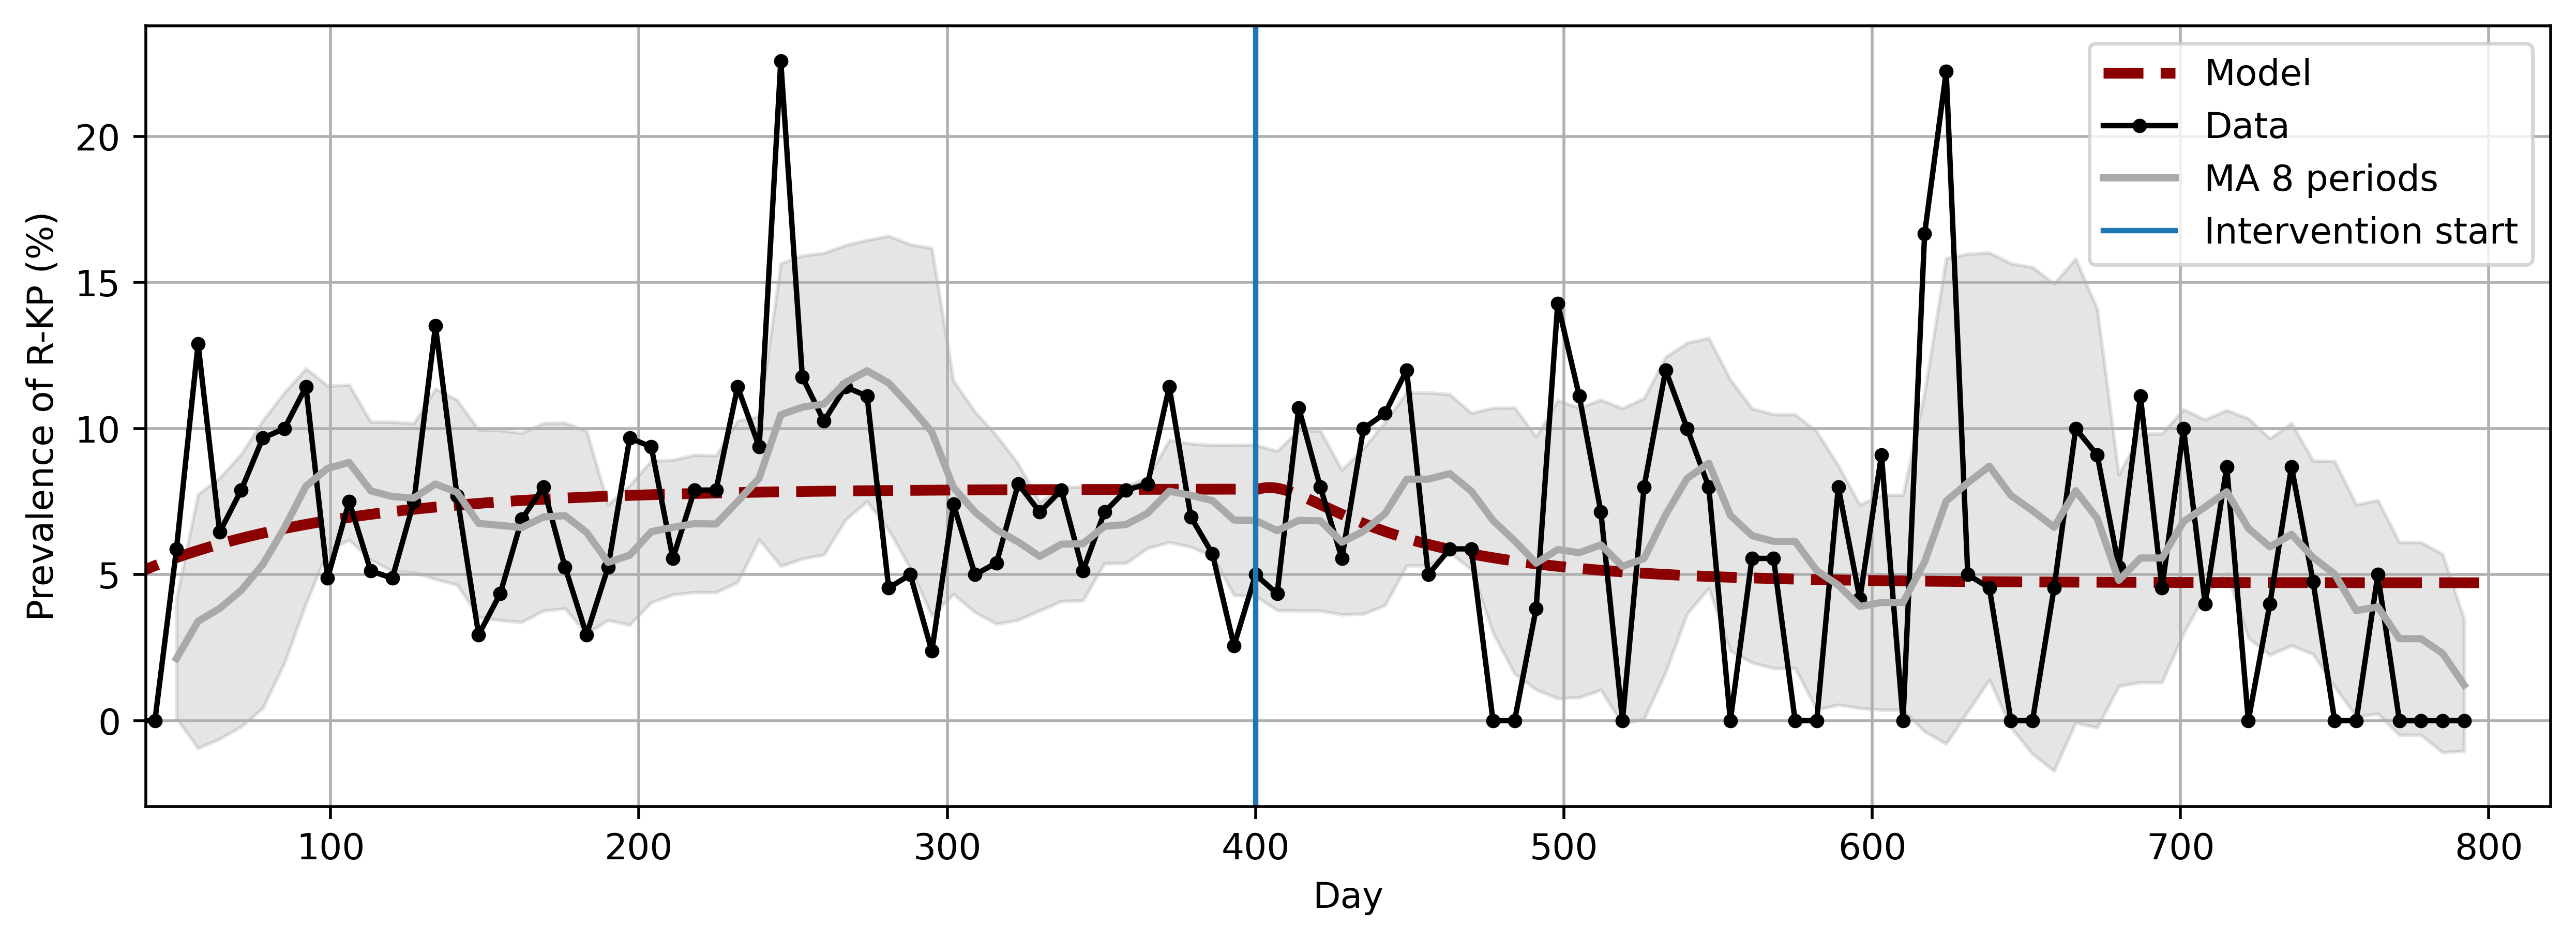

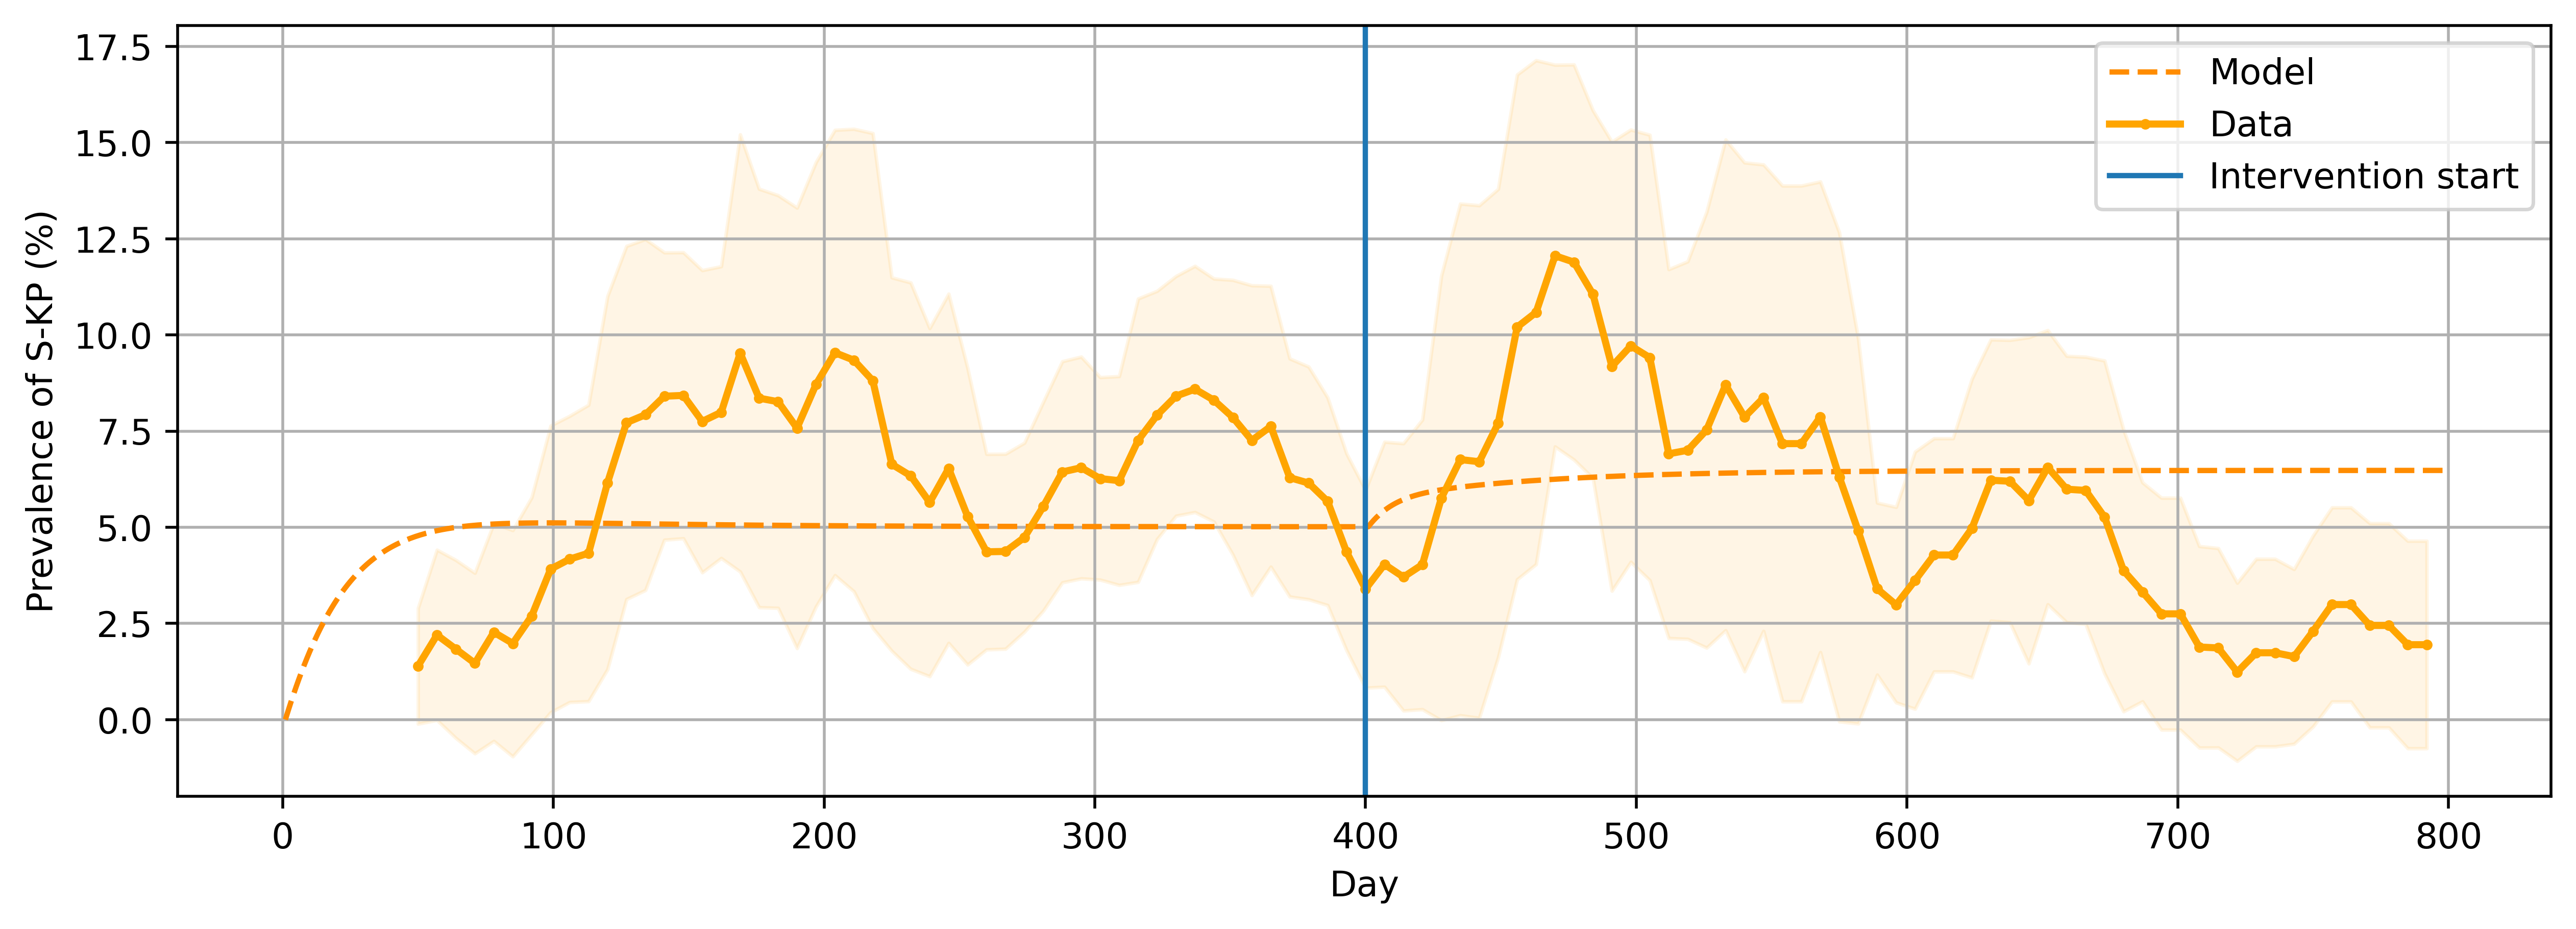

In [71]:
my_pal={'Sensitive':'orange','Resistant':'r','Uncolonized':'g',
        'HCW uncolonized':'darkgreen','HCW sensitive':'darkorange',
        'HCW resistant':'darkred'}
Presplot=res.melt('Day',res.columns[:3],var_name='Type',value_name='Population')
Hresplot=res.melt('Day',res.columns[3:6],var_name='Type',value_name='HCWs')
fig,axs=plt.subplots(1,2, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y='Population',hue='Type',data=Presplot,ax=axs[0],
             palette=my_pal)
axs[1].plot(daily_data.Day,daily_data.Free,color='green')
axs[1].plot(daily_data.Day,daily_data.Sensitive,color='orange')
axs[1].plot(daily_data.Day,daily_data.Resistant,color='red')
#axs[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=7*8))
#plt.setp( axs[0,1].xaxis.get_majorticklabels(), rotation=50,fontsize=8 )
axs[1].axvline(daily_data.loc[int_day,'Day'])
axs[0].axvline(daily_data.loc[int_day,'Day'])
axs[0].set_xlim(0,days)
axs[0].set_ylim(0,B)
axs[0].legend(loc='upper right')
axs[1].set_ylim(0,B)
axs[1].set_xlim(0,days)
axs[0].set_ylabel('Patients')
axs[0].set_title('Model')
axs[1].set_title('Data')
#axs[1].set_ylabel('Data population')

time_series_df = pd.DataFrame(data.Resistant/data.n_patients*100).set_index(data.Day)
smooth_path    = time_series_df.rolling(8).mean()
path_deviation =  time_series_df.rolling(8).std()
under_line     = (smooth_path-path_deviation)[0]
over_line      = (smooth_path+path_deviation)[0]
#Plotting:
fig,axs=plt.subplots(1,1, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y=res['Prevalence R-KP']*100,data=res,ax=axs,linestyle='--',color='darkred',label='Model',linewidth=3)
axs.plot(data.Day, data.Resistant/data[['Free','Sensitive','Resistant']].sum(1)*100, marker='o',markersize=3,
             color='black',label='Data')
plt.plot(smooth_path, linewidth=2,color='darkgrey',label='MA 8 periods') #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='black', alpha=.1) #std curves.
plt.axvline(400, label='Intervention start')
axs.set_xlim(40,820)
axs.legend()
#axs[1,0].set_ylabel('Monthly IR (per 10k pd)')
axs.set_ylabel('Prevalence of R-KP (%)')
axs.grid()


time_series_df = pd.DataFrame(data.Sensitive/data.n_patients*100).set_index(data.Day)
smooth_path    = time_series_df.rolling(8).mean()
path_deviation =  time_series_df.rolling(8).std()
under_line     = (smooth_path-path_deviation)[0]
over_line      = (smooth_path+path_deviation)[0]
fig,axs=plt.subplots(1,1, figsize=(12,4),sharex=True,dpi=500)
sns.lineplot(x='Day',y=res['Prevalence S-KP']*100,data=res,ax=axs,linestyle='--',color='darkorange',label='Model')
#axs.plot(data.Day, data.Sensitive/data[['Free','Sensitive','Resistant']].sum(1)*100,
#             color='orange',label='Data')
plt.plot(smooth_path, linewidth=2,color='orange',marker='o',label='Data',markersize=2) #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='orange', alpha=.1) #std curves.
plt.axvline(400, label='Intervention start')
axs.legend()
#axs[1,0].set_ylabel('Monthly IR (per 10k pd)')
axs.set_ylabel('Prevalence of S-KP (%)')
axs.grid()